## Assignment 2  
### Hasnain Hossain a1945656

In [ ]:
!pip install hf_xet transformers torch bertopic 'accelerate>=0.26' wordcloud sentence-transformers

In [72]:
from random import sample
from collections import Counter
from tqdm import tqdm

from torch.utils.data import Dataset

from sentence_transformers import SentenceTransformer

from transformers import (
    pipeline,
    Trainer,
    TextDataset,
    TrainingArguments,
    BertTokenizerFast,
    EarlyStoppingCallback,
    BertForSequenceClassification,
)

from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    silhouette_score,
    confusion_matrix,
    classification_report
)

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import os
import re
import torch
import string
import pickle
import datetime
import itertools
import collections

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# Inline plots in Jupyter
%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [ ]:
'''
For Google Colab
'''

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:
def merge_csvs(data_folder, output_file):
    # Folder containing your yearly CSVs
    csv_files = [f for f in os.listdir() if f.endswith('.csv')]

    # Hold all the DataFrames
    dataframes = []

    for file in csv_files:
        file_path = os.path.join(data_folder, file)
        print(f"Reading: {file_path}")
        df = pd.read_csv(file_path)
        dataframes.append(df)

    # Concat
    merged_df = pd.concat(dataframes, ignore_index=True)

    merged_df.drop_duplicates(inplace=True)

    output_path = os.path.join(data_folder, output_file)
    merged_df.to_csv(output_path, index=False)
    print(f"Done. Merged file saved to: {output_path}")

# data_folder = 'data'
# output_file = 'stitched_data.csv'
# merge_csvs(data_folder, output_file)

In [4]:
df = pd.read_csv('data/raw_stackoverflow/raw_stitched.csv')
df.shape

(8489, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8489 entries, 0 to 8488
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   QuestionId      8489 non-null   int64 
 1   Title           8489 non-null   object
 2   Description     8489 non-null   object
 3   Tags            8489 non-null   object
 4   AcceptedAnswer  8489 non-null   object
 5   OtherAnswers    2968 non-null   object
dtypes: int64(1), object(5)
memory usage: 398.0+ KB


In [6]:
df.head()

,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers
0,41403862,What are trained models in NLP?,<p>I am new to Natural language processing. Ca...,<java><nlp><stanford-nlp><opennlp>,"<p>A ""model"" <a href=""http://opennlp.sourcefor...","<p>Think of trained model as a ""wise brain wit..."
1,41398680,Error loading list when adding a list to Arabi...,<p>I tried to add a new list to the arabic plu...,<nlp><named-entity-recognition><gate>,<p>The Problem was due to two major issues whi...,NaN
2,41381728,delete specific words in a file,<p>I want to delete stop words in a file (it c...,<python-3.x><nlp>,<p>I found the problem. That's because in some...,NaN
3,41356198,Extract entities from folksonomies,<p>I am a newbie to NLP and related technologi...,<nlp><stanford-nlp>,<p>What you are looking for is a compound spli...,<p>Have you tried the method suggested here?</...
4,41355664,How to convert numeric words into numeric in p...,<p>I want to convert numeric which represented...,<python><nlp><fuzzy>,"<p>For numbers to words, try ""num2words"" packa...",NaN


In [7]:
def generate_samples(high, to_sample=6):
    return np.random.randint(high, size=to_sample)

def print_samples(data):
    for col in range(data.shape[1]):
        # Samples some rows to extract
        indices = generate_samples(data.shape[0])
        samples = data.iloc[indices, col]

        print(f'Samples from {data.columns[col]} column:')

        for item in samples:
            print(item)
        print('\n')

# Select number of items to sample
to_sample = 6

print_samples(df)

Samples from QuestionId column:
19574549
60352003
67612600
54305070
27766869
19096124


Samples from Title column:
How to Compare strings of 1 column with strings of another within the same dataframe, calculate the percentage of strings matching in result columns
spacy tokenizer is not recognizing period as suffix consistently
NLP PROLOG Grammar
Is this the correct definition of a "corpus"?
Turning a sentence from first to second person
Why is NLTK's PoS tagger tagging for each letter in a word instead of tagging for each word?


Samples from Description column:
<p>I followed this azure's guide to build a simple question answering bot: <a href="https://microsoftlearning.github.io/AI-900-AIFundamentals/instructions/04d-create-a-bot.html#create-a-bot-for-the-knowledge-base" rel="noreferrer">https://microsoftlearning.github.io/AI-900-AIFundamentals/instructions/04d-create-a-bot.html#create-a-bot-for-the-knowledge-base</a></p>
<p>Everything works fine until deployment(last section).</p>
<p

### Global Utility Functions

In [24]:
def log_data_info(df, log_file):
    with open(log_file, 'a') as f:
        f.write(f"Data loaded at {datetime.datetime.now()}\n")
        f.write(f"Shape: {df.shape}\n")
        f.write("Columns: " + ', '.join(df.columns) + "\n\n")

def log_experiment(params, metrics, filename="experiment_log.json"):
    entry = {
        "timestamp": datetime.datetime.now().isoformat(),
        "params": params,
        "metrics": metrics
    }
    with open(filename, 'a') as f:
        f.write(json.dumps(entry) + "\n")

def remove_singles(df):
    counts = df['human_label'].value_counts()
    to_drop = counts[counts == 1].index

    df = df[~df['human_label'].isin(to_drop)].reset_index(drop=True)
    print(df.shape)
    return df

def find_duplicates(df, col):
    '''
    Remove any duplicate rows that may have crept in
    '''
    dupes = df[df.duplicated(subset=col, keep=False)]
    print(f'Duplicates dataframe based on {col}:', len(dupes))
    print(dupes.sort_values("QuestionId"))

### Preprocessing Functions

In [8]:
'''
preprocessing.py
'''

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def process_text(text,
                 do_lower=True,
                 remove_urls=True,
                 remove_html=True,
                 remove_punct=True,
                 remove_stopwords=True,
                 use_stemming=False,
                 use_lemmatization=False,
                 return_as_tokens=False):
    '''
    Code adapted from function defined in first project
    '''

    if not isinstance(text, str):
        text = str(text) if text else ''

    if do_lower:
        text = text.lower()

    if remove_urls:
        # e.g. remove anything that looks like an http or www link
        text = re.sub(r'http\S+|www\S+|pic.twitter\S+|imgur\S+|!\[.*?\]\(.*?\)', '', text)

    if remove_html:
        text = re.sub(r'<[^>]+>', '', text)

    tokens = word_tokenize(text)

    if remove_punct:
        tokens = [t for t in tokens if t not in string.punctuation]

    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]

    # Either stem or lemmatize
    processed = []
    for w in tokens:
        if use_stemming:
            w = stemmer.stem(w)
        elif use_lemmatization:
            w = lemmatizer.lemmatize(w)
        processed.append(w)

    # Return as tokens or joined string
    if return_as_tokens:
        return processed
    else:
        return " ".join(processed)


def parse_bracketed_tags(tag_str):
    '''
    Example input: '<java><nlp><stanford-nlp><opennlp>'
    Output: ['java', 'nlp', 'stanford-nlp', 'opennlp']

    re.findall(r"<(.*?)>", "<java><nlp>") -> ['java','nlp']
    '''
    if not isinstance(tag_str, str):
        return []
    matches = re.findall(r'<([^>]+)>', tag_str)
    return matches


def process_other_answers(text):
    '''
    text: the raw content of OtherAnswers, presumably multiple answers
    separated by \n (line breaks) returns a single combined cleaned string

    We've implemented this function because there may be different
    handling mechanisms for the OtherAnswers column
    '''
    if not isinstance(text, str):
        return ''

    answers = text.split('\n')

    # Clean each piece
    cleaned_answers = []
    for ans in answers:
        c = process_text(ans)
        cleaned_answers.append(c)

    # Join them into a single big chunk
    return ' '.join(cleaned_answers)

def combine_columns_for_embedding(row):
    '''
    Row-wise operation. Pass axis=1 when calling the function
    '''
    return (row['clean_title'] + " " + row['clean_description']).strip()

In [9]:
'''
Apply Preprocessing to relevant columns
'''
df['clean_title'] = df['Title'].apply(lambda x: process_text(
    x,
    do_lower=True,
    remove_urls=True,
    remove_html=True,
    remove_punct=True,
    remove_stopwords=True,
    use_stemming=False,
    use_lemmatization=False,
    return_as_tokens=False
))

df['clean_description'] = df['Description'].apply(lambda x: process_text(x))

df['clean_accepted_answer'] = df['AcceptedAnswer'].apply(lambda x: process_text(x))

df['clean_other_answers'] = df['OtherAnswers'].apply(process_other_answers)

df['tag_list'] = df['Tags'].apply(parse_bracketed_tags)

df['combined_title_desc'] = df.apply(combine_columns_for_embedding, axis=1)

df.head()

,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers,clean_title,clean_description,clean_accepted_answer,clean_other_answers,tag_list,combined_title_desc
0,41403862,What are trained models in NLP?,<p>I am new to Natural language processing. Ca...,<java><nlp><stanford-nlp><opennlp>,"<p>A ""model"" <a href=""http://opennlp.sourcefor...","<p>Think of trained model as a ""wise brain wit...",trained models nlp,new natural language processing anyone tell tr...,`` model '' downloadable opennlp set data repr...,think trained model `` wise brain existing inf...,"[java, nlp, stanford-nlp, opennlp]",trained models nlp new natural language proces...
1,41398680,Error loading list when adding a list to Arabi...,<p>I tried to add a new list to the arabic plu...,<nlp><named-entity-recognition><gate>,<p>The Problem was due to two major issues whi...,NaN,error loading list adding list arabic plugin g...,tried add new list arabic plugin gazetteer fol...,problem due two major issues file saved correc...,,"[nlp, named-entity-recognition, gate]",error loading list adding list arabic plugin g...
2,41381728,delete specific words in a file,<p>I want to delete stop words in a file (it c...,<python-3.x><nlp>,<p>I found the problem. That's because in some...,NaN,delete specific words file,want delete stop words file contains sentence ...,found problem 's words punctuation attaches wo...,,"[python-3.x, nlp]",delete specific words file want delete stop wo...
3,41356198,Extract entities from folksonomies,<p>I am a newbie to NLP and related technologi...,<nlp><stanford-nlp>,<p>What you are looking for is a compound spli...,<p>Have you tried the method suggested here?</...,extract entities folksonomies,newbie nlp related technologies researching de...,looking compound splitter far know problem imp...,tried method suggested href= '' issue dictio...,"[nlp, stanford-nlp]",extract entities folksonomies newbie nlp relat...
4,41355664,How to convert numeric words into numeric in p...,<p>I want to convert numeric which represented...,<python><nlp><fuzzy>,"<p>For numbers to words, try ""num2words"" packa...",NaN,convert numeric words numeric python,want convert numeric represented words numbers...,numbers words try `` num2words '' package word...,,"[python, nlp, fuzzy]",convert numeric words numeric python want conv...


### Data Visualization

1. Take the preprocessed titles, remove stop words, possibly remove common developer-specific words (“code,” “error,” “issue,” etc.) if they overshadow the actual NLP terms.  
2. Distribution of tags (bar chart showing how many posts use spacy, nltk, bert, etc.).  
3. Timeline of posts (how many posts per year/month).  
4. Scatter plot or histogram of number of views.


In [10]:
print("\nNumber of unique posts with an accepted answer:",
      df['clean_accepted_answer'].notna().sum())

# Find the average length of posts
df['desc_length'] = df['clean_description'].apply(lambda x: len(str(x).split()))
print("\nAverage token count in description:",
      df['desc_length'].mean())

df.head()


Number of unique posts with an accepted answer: 8489

Average token count in description: 121.87548592295913


,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers,clean_title,clean_description,clean_accepted_answer,clean_other_answers,tag_list,combined_title_desc,desc_length
0,41403862,What are trained models in NLP?,<p>I am new to Natural language processing. Ca...,<java><nlp><stanford-nlp><opennlp>,"<p>A ""model"" <a href=""http://opennlp.sourcefor...","<p>Think of trained model as a ""wise brain wit...",trained models nlp,new natural language processing anyone tell tr...,`` model '' downloadable opennlp set data repr...,think trained model `` wise brain existing inf...,"[java, nlp, stanford-nlp, opennlp]",trained models nlp new natural language proces...,23
1,41398680,Error loading list when adding a list to Arabi...,<p>I tried to add a new list to the arabic plu...,<nlp><named-entity-recognition><gate>,<p>The Problem was due to two major issues whi...,NaN,error loading list adding list arabic plugin g...,tried add new list arabic plugin gazetteer fol...,problem due two major issues file saved correc...,,"[nlp, named-entity-recognition, gate]",error loading list adding list arabic plugin g...,124
2,41381728,delete specific words in a file,<p>I want to delete stop words in a file (it c...,<python-3.x><nlp>,<p>I found the problem. That's because in some...,NaN,delete specific words file,want delete stop words file contains sentence ...,found problem 's words punctuation attaches wo...,,"[python-3.x, nlp]",delete specific words file want delete stop wo...,163
3,41356198,Extract entities from folksonomies,<p>I am a newbie to NLP and related technologi...,<nlp><stanford-nlp>,<p>What you are looking for is a compound spli...,<p>Have you tried the method suggested here?</...,extract entities folksonomies,newbie nlp related technologies researching de...,looking compound splitter far know problem imp...,tried method suggested href= '' issue dictio...,"[nlp, stanford-nlp]",extract entities folksonomies newbie nlp relat...,37
4,41355664,How to convert numeric words into numeric in p...,<p>I want to convert numeric which represented...,<python><nlp><fuzzy>,"<p>For numbers to words, try ""num2words"" packa...",NaN,convert numeric words numeric python,want convert numeric represented words numbers...,numbers words try `` num2words '' package word...,,"[python, nlp, fuzzy]",convert numeric words numeric python want conv...,31


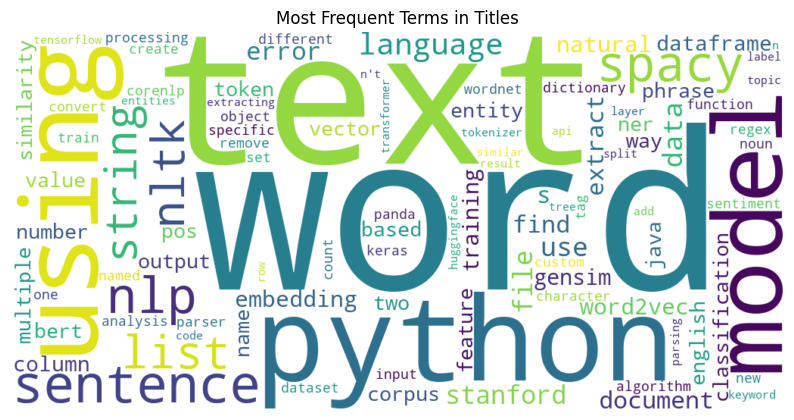

In [ ]:
all_titles_text = " ".join(df['clean_title'].dropna().tolist())

wordcloud = WordCloud(width=1024, height=500,
                      background_color='white',
                      max_words=100,
                      collocations=False
                      ).generate(all_titles_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in Titles")
plt.show()


Let's also take a look at the top 20 tags. This is going to help us get a feel for the different possible categories

In [ ]:
all_tags = []
for tags in df['tag_list']:
    if tags:
        all_tags.extend(tags)

tag_counts = Counter(all_tags)
top_tags = tag_counts.most_common(20)

for t, c in top_tags:
    print(f"{t}: {c}")


nlp: 8489
python: 4181
nltk: 1113
machine-learning: 1053
spacy: 756
stanford-nlp: 599
python-3.x: 520
java: 498
pandas: 405
r: 397
gensim: 342
word2vec: 341
regex: 340
tensorflow: 325
scikit-learn: 314
huggingface-transformers: 303
deep-learning: 294
named-entity-recognition: 273
keras: 265
pytorch: 236


We can also take a count of the accepted and other answers.

In [78]:
df_visuals.head()

,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers,clean_title,clean_description,clean_accepted_answer,clean_other_answers,tag_list,combined_title_desc,desc_length,num_tags,num_other_answers
0,41403862,What are trained models in NLP?,<p>I am new to Natural language processing. Ca...,<java><nlp><stanford-nlp><opennlp>,"<p>A ""model"" <a href=""http://opennlp.sourcefor...","<p>Think of trained model as a ""wise brain wit...",trained models nlp,new natural language processing anyone tell tr...,`` model '' downloadable opennlp set data repr...,think trained model `` wise brain existing inf...,"[java, nlp, stanford-nlp, opennlp]",trained models nlp new natural language proces...,23,4,6
1,41398680,Error loading list when adding a list to Arabi...,<p>I tried to add a new list to the arabic plu...,<nlp><named-entity-recognition><gate>,<p>The Problem was due to two major issues whi...,NaN,error loading list adding list arabic plugin g...,tried add new list arabic plugin gazetteer fol...,problem due two major issues file saved correc...,,"[nlp, named-entity-recognition, gate]",error loading list adding list arabic plugin g...,124,3,0
2,41381728,delete specific words in a file,<p>I want to delete stop words in a file (it c...,<python-3.x><nlp>,<p>I found the problem. That's because in some...,NaN,delete specific words file,want delete stop words file contains sentence ...,found problem 's words punctuation attaches wo...,,"[python-3.x, nlp]",delete specific words file want delete stop wo...,163,2,0
3,41356198,Extract entities from folksonomies,<p>I am a newbie to NLP and related technologi...,<nlp><stanford-nlp>,<p>What you are looking for is a compound spli...,<p>Have you tried the method suggested here?</...,extract entities folksonomies,newbie nlp related technologies researching de...,looking compound splitter far know problem imp...,tried method suggested href= '' issue dictio...,"[nlp, stanford-nlp]",extract entities folksonomies newbie nlp relat...,37,2,12
4,41355664,How to convert numeric words into numeric in p...,<p>I want to convert numeric which represented...,<python><nlp><fuzzy>,"<p>For numbers to words, try ""num2words"" packa...",NaN,convert numeric words numeric python,want convert numeric represented words numbers...,numbers words try `` num2words '' package word...,,"[python, nlp, fuzzy]",convert numeric words numeric python want conv...,31,3,0


In [105]:
def parse_bracketed_tags(tag_string: str):
    return re.findall(r'<([^<>]+)>', str(tag_string))

df_visuals = df.copy()

desc_length = df_visuals['clean_description'].fillna('').apply(lambda x: len(str(x).split()))

# Accepted answer word counts
accepted_len = df_visuals['clean_accepted_answer'].fillna('').apply(lambda x: len(str(x).split()))
other_answers_len = df_visuals['clean_other_answers'].fillna('').apply(lambda x: len(str(x).split()))

# Tags
tag_list = df_visuals['Tags'].apply(parse_bracketed_tags)
df_visuals['num_tags'] = tag_list.apply(len)

tag_counter = collections.Counter(itertools.chain.from_iterable(tag_list))

# Top‑10 co‑tags excluding 'nlp'
co_tag_counts = [(tag, cnt) for tag, cnt in tag_counter.items() if tag!='nlp']
co_tag_counts = sorted(co_tag_counts, key=lambda x: x[1], reverse=True)[:10]

print("\nTop‑10 co‑tags (besides 'nlp'):")
for tag,cnt in co_tag_counts:
    print(f"  {tag:<20} {cnt:>6}")

# Number of other answers
df_visuals['num_other_answers'] = df_visuals['clean_other_answers'].apply(lambda x: len(str(x)))



Top‑10 co‑tags (besides 'nlp'):
  python                 4181
  nltk                   1113
  machine-learning       1053
  spacy                   756
  stanford-nlp            599
  python-3.x              520
  java                    498
  pandas                  405
  r                       397
  gensim                  342


In [96]:
accepted_len.describe()

count    8489.000000
mean      100.224290
std       128.244915
min         0.000000
25%        34.000000
50%        66.000000
75%       122.000000
max      2712.000000
Name: clean_accepted_answer, dtype: float64

In [94]:
df_visuals['num_other_answers'].describe()

count     8489.000000
mean       328.938862
std       1079.903076
min          0.000000
25%          0.000000
50%          0.000000
75%        270.000000
max      40383.000000
Name: num_other_answers, dtype: float64

In [104]:
desc_length.describe()

count    8489.000000
mean      121.875486
std       168.394186
min         3.000000
25%        46.000000
50%        82.000000
75%       143.000000
max      5461.000000
Name: clean_description, dtype: float64

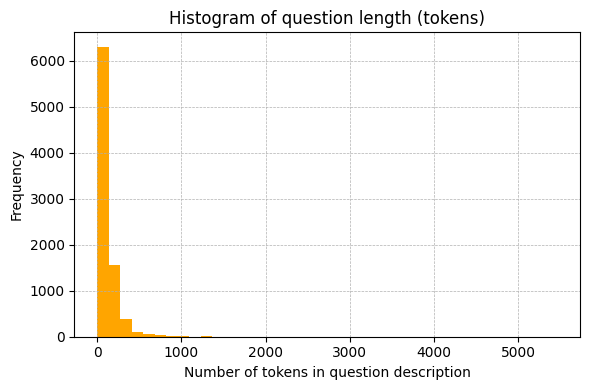

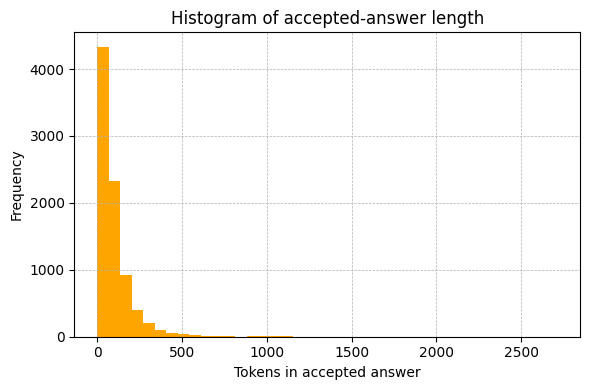

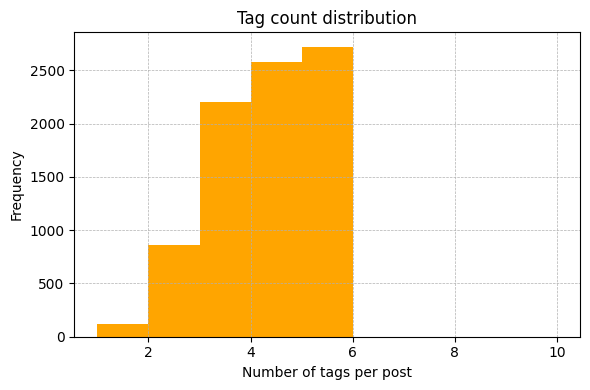

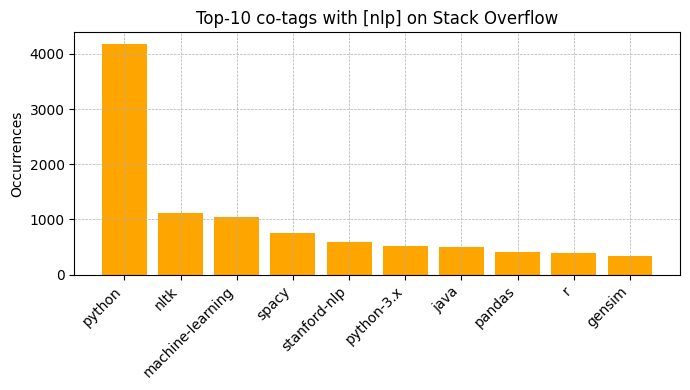

In [103]:
plt.figure(figsize=(6,4))
plt.hist(desc_length, bins=40, color='orange')
plt.xlabel("Number of tokens in question description")
plt.ylabel("Frequency")
plt.title("Histogram of question length (tokens)")
plt.tight_layout()
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(accepted_len, bins=40, color='orange')
plt.xlabel("Tokens in accepted answer")
plt.ylabel("Frequency")
plt.title("Histogram of accepted‑answer length")
plt.tight_layout()
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_visuals['num_tags'], bins=range(1,11), color='orange')
plt.xlabel("Number of tags per post")
plt.ylabel("Frequency")
plt.title("Tag count distribution")
plt.tight_layout()
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.show()

tags, counts = zip(*co_tag_counts)
plt.figure(figsize=(7,4))
plt.bar(tags, counts, color='orange')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Occurrences")
plt.title("Top‑10 co‑tags with [nlp] on Stack Overflow")
plt.tight_layout()
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.show()

We can observe the following:

| Obs.     | Value   | Comment |
| -------- | ------- | ------- |
| Total [nlp] questions on Stack Overflow  | 20,974   | Provided in assignment brief.     |
| Posts with an accepted answer (our CSV) | 8,489     | 40 % of all [nlp] posts.     |
| Avg. tokens in question body    | 122 ± 168    | Long‑tailed; median ≈ 82.    |
| Avg. tokens in accepted answer    | 100 ± 128    | Slightly shorter than questions; median ≈ 66.    |
| Median number of tags per post    | 4    | 75 % of posts carry 3–6 tags.    |
| Avg. other answers per post    | 9.2    | Heavily skewed; median 0 (most Qs have no extras, but a few have hundreds).    |


Only four in ten [nlp] questions ever get an accepted answer—the rest remain “open”; this aligns with anecdotal complaints about unanswered niche NLP queries. Both questions and answers are fairly verbose (150–170 tokens on average), reflecting the technical detail typical of code‑and‑text issues. Most posts use several tags, confirming that NLP problems rarely live in isolation—they overlap with languages, libraries or ML themes.


### Data Categorization

We have multiple possible strategies to establish the core task of categorizing posts. Outlined are the following possible ways:

1. **Rule-based or Keyword-based**

- Example: if the title has “how to” or “how do I,” classify it into “Implementation Issues.”  
- If the title has “what” or “why,” classify it into “Basic Understanding or Conceptual Queries.”  
- Use sets of keywords for known categories (e.g., “BERT,” “Hugging Face,” “transformers” → “Transformers-based library issues”).  
- Similarly, if the question is about “tokenization,” “lemmatization,” “stemming,” you can classify them under “Text Preprocessing Tasks,” etc.

2. **Clustering Approach**
- We could vectorize the titles using TF-IDF or a transformer-based embedding (e.g., Sentence-BERT). In the vectorization step we convert each document (in our case, each title or maybe title and description) into a vector of TF-IDF scores. Each dimension of the vector corresponds to a word in our vocabulary.  

- Alternatively, instead of using a count-based or TF-IDF-based approach, we can also use a pretrained model (e.g., sentence-transformers library in Python) that maps each text snippet to a dense vector—often 384 or 768 dimensions, depending on the model. Because BERT-based embeddings capture semantic information, we might get more meaningful clusters for short text.  

- We cam run an unsupervised clustering (like K-Means) to see natural groupings, and then interpret each cluster to assign a category label. The challenge here is to identify the value of k, and then interpreting the clusters. To do this, we might look at the top 10 items from that cluster to guess the category's theme. Following the interpretation, we will have to assign category names, by creating a mapping of cluster IDs to labels.  

3. **Combination Approach**
- We might also approach this as a semi-supervised task. We use a rule-based approach for high-precision categories you already know (like “How to?” queries). We can label a small subset of points this way.
- We can follow that with clustering to group the rest.

This avenue is interesting because we can explore different ways of combining the approaches:  

**Rule-based first**
- If the title matches obvious “How to” or “What is” patterns, you assign it to an existing category.  
- Everything that doesn’t match is fed into an unsupervised clustering approach, which might reveal new category “themes.”

**Clustering first**

- Here, we cluster the entire dataset, interpret the clusters, name them.

- Then we write rules that best capture those clusters. This is effectively turning an unsupervised approach into a more deterministic rule-based approach.

- Since we don't have labeled data, we can leverage BERT as a sentence (or document) encoder: We can pass each post’s text through BERT (or Sentence-BERT, etc.) to get a fixed-size embedding. Then, we cluster those embeddings. The issue is we still don't have an automatic way of deciding the number of clusters



#### Store Categorization

Maintain a table or CSV with columns [post_id, title, assigned_category, rationale/keywords_matched, date, etc.].

For this, we might start with a rule-based approach because it’s simpler, interpretable, and meets the assignment’s requirement of explaining how we categorize the posts.  

We can optionally do short-text clustering with Sentence-BERT.


### Experimental Plan

1. Data Loading:

- A function load_data(filepath: str) -> pd.DataFrame in your data_collection or utils module.  

2. Preprocessing:

- A function clean_text(text: str) -> str that does lowercasing, punctuation removal, and so on.  
- A function tokenize(text: str) -> List[str].
- Possibly a pipeline function preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame that applies these transformations to all relevant columns.

3. Visualization:

- A function generate_wordcloud(text_data: List[str], output_path: str) that handles all word cloud generation.  
- Additional plotting functions plot_tag_distribution(df: pd.DataFrame) etc.
  
4. Categorization:

- A function assign_category(row: pd.Series) -> str with your rule-based logic.  
- Another function categorize_posts(df: pd.DataFrame) -> pd.DataFrame that applies the above logic to each row and returns the categorized DataFrame.  

4. Storing Artifacts:

- Have a function save_model(model, filename: str) that pickles your model.  
- For categorization, you might not have a “model,” but if you do any advanced approach (like clustering), you can store the resulting cluster centers or classification pipelines.  
- Keep logs in something like experiment_results/experiment_001/ with a timestamp.



### Embedding with BERT and Clustering Approach

We will use `sentence_transformers` (e.g., the `SentenceTransformer` class) to generate embeddings. We will store those embeddings for

future runs, so we don’t have to recompute them each time we tweak our clustering parameters.

In [ ]:
class EmbeddingGenerator:
    def __init__(self, model_name, output_dir="models/"):
        self.model = SentenceTransformer(model_name)
        self.model_name = model_name
        self.output_dir = output_dir

        # Ensure the output directory exists
        os.makedirs(self.output_dir, exist_ok=True)

    def generate_embeddings(self, texts, batch_size=32):
        embeddings = self.model.encode(texts, batch_size=batch_size, show_progress_bar=True)
        return embeddings

    def save_embeddings(self, embeddings: np.ndarray, file_name):
        file_path = os.path.join(self.output_dir, file_name)

        # Ensure directory exists, create if it doesn't
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, 'wb') as f:
            pickle.dump(embeddings, f)
        return file_path

    def load_embeddings(self, file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)


For our unsupervised technique, we will use k-means to get an understanding of the natural groupings

In [ ]:
class Clusterer:
    def __init__(self, method='kmeans', n_clusters=10):
        self.method = method
        self.n_clusters = n_clusters
        self.model = None

    def fit(self, embeddings: np.ndarray):
        if self.method == 'kmeans':
            self.model = KMeans(n_clusters=self.n_clusters, random_state=42)
            self.model.fit(embeddings)
        '''
        We can add other clustering methods like DBSCAN if we wanted to
        '''

    def predict(self, embeddings: np.ndarray):
        return self.model.predict(embeddings)

    def save_model(self, output_dir="models/"):
        file_path = os.path.join(
            output_dir,
            f"{self.method}_{self.n_clusters}_clusters_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
        )
        # Ensure directory exists, create if it doesn't
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, 'wb') as f:
            pickle.dump(self.model, f)
        return file_path


In [ ]:
'''
Pipeline for sentence transformer embedding
'''

embedding_model_name = "all-MiniLM-L6-v2"
embedder = EmbeddingGenerator(model_name=embedding_model_name)

# Generate embeddings for the combined text
texts = df['combined_title_desc'].tolist()
embeddings = embedder.generate_embeddings(texts, batch_size=32)

print("Embeddings shape:", embeddings.shape)  # e.g., (N, 768) for N documents

Batches: 100%|███████████████████████████████████████████████████████████████████████████████| 266/266 [00:40<00:00,  6.53it/s]

Embeddings shape: (8489, 384)


In [ ]:
# Save embeddings for future re-use
embedder.save_embeddings(embeddings, file_name=f'bert_embeddings_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')

'models/bert_embeddings_20250404_050119.pkl'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


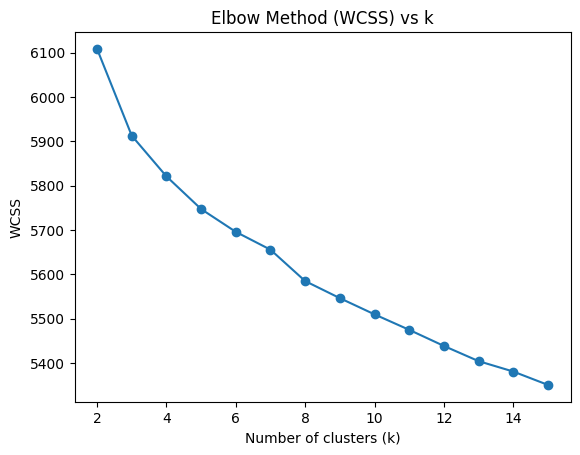

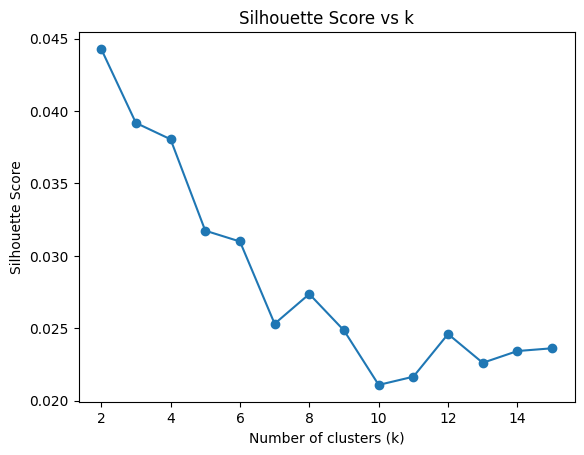

In [ ]:
def find_optimal_k(embeddings, k_min=2, k_max=15):
    wcss_list = []
    silhouette_list = []

    for k in range(k_min, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        labels = kmeans.labels_

        wcss = kmeans.inertia_
        wcss_list.append(wcss)

        sil_score = silhouette_score(embeddings, labels)
        silhouette_list.append(sil_score)

    # Plot the elbow
    plt.figure()
    plt.plot(range(k_min, k_max+1), wcss_list, marker='o')
    plt.title("Elbow Method (WCSS) vs k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("WCSS")
    plt.show()

    # Plot silhouette scores
    plt.figure()
    plt.plot(range(k_min, k_max+1), silhouette_list, marker='o')
    plt.title("Silhouette Score vs k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.show()

    # Return the raw data so you can examine
    return wcss_list, silhouette_list

# Example usage:
wcss_list, silhouette_list = find_optimal_k(embeddings, k_min=2, k_max=15)

From those two plots (WCSS vs. k and Silhouette Score vs. k), our main takeaway is that there is no strong evidence of well-separated clusters in your data when using BERT embeddings with K-Means. There is no Clear “Elbow”: The Elbow (WCSS) plot does not show a pronounced bend or inflection point. We do not see any sharp decrease that flattens out at some k, indicating an optimal number of clusters. Here, the curve steadily decreases but never levels off distinctly, making it difficult to justify one particular k over another.

The Silhouette Score is relatively low overall (around 0.04–0.05 at best, then dropping as k increases). In practice, Silhouette Scores closer to 1 indicate highly dense and well-separated clusters, while scores near 0 suggest overlapping clusters or no substantial structure. Scores in the 0.02–0.05 range typically indicate weak clustering structure.

These observations imply that the data, as embedded by BERT and clustered via K-Means, does not naturally break down into tight, well-defined groups. This does not necessarily mean that topic modeling or clustering is impossible—it just means K-Means on raw BERT embeddings might not be the best fit for uncovering meaningful topics.

K-Means with BERT embeddings, at least in its current form, is not producing strong or clear-cut clusters. We will try a semi-supervised approach, manually labeling a subset of data, and attempting to train a BERT classifier against it.

In [ ]:
num_clusters = 8

clusterer = Clusterer(method='kmeans', n_clusters=num_clusters)
clusterer.fit(embeddings)

# Now get cluster labels for each post
cluster_labels = clusterer.predict(embeddings)
df['cluster_label'] = cluster_labels

# cluster_model_path = clusterer.save_model(output_dir="models/")
# print("Cluster model saved to:", cluster_model_path)

In [ ]:
all_texts = df['combined_title_desc'].tolist()

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(all_texts)

feature_names = tfidf.get_feature_names_out()

# For each cluster, find top terms by average TF-IDF
num_clusters = num_clusters  # same as you used in K-Means
for cluster_id in range(num_clusters):
    cluster_indices = df[df['cluster_label'] == cluster_id].index
    if len(cluster_indices) == 0:
        print(f"Cluster {cluster_id} is empty.")
        continue

    # Subset the rows in the TF-IDF matrix for this cluster
    cluster_matrix = X_tfidf[cluster_indices]

    # Compute average TF-IDF for each term within this cluster
    avg_tfidf = cluster_matrix.mean(axis=0).A1  # .A1 to convert sparse matrix to 1D array

    # Get top 10 terms
    top_indices = np.argsort(avg_tfidf)[::-1][:10]
    top_terms = [feature_names[i] for i in top_indices]

    print(f"\nCluster {cluster_id} (size: {len(cluster_indices)}):")
    print("Top terms:", top_terms)



Cluster 0 (size: 1015):
Top terms: ['quot', 'df', 'dataframe', 'text', 'column', 'data', 'words', 'word', 'lt', 'pandas']

Cluster 1 (size: 1056):
Top terms: ['model', 'quot', 'self', 'tf', 'keras', 'tokenizer', 'bert', 'embedding', 'shape', 'layer']

Cluster 2 (size: 521):
Top terms: ['spacy', 'quot', 'doc', 'nlp', 'token', 'load', 'text', 'import', 'ner', 'matcher']

Cluster 3 (size: 1417):
Top terms: ['quot', 'words', 'text', 'word', 'gt', 'string', 'list', 'python', 'nltk', 'sentence']

Cluster 4 (size: 743):
Top terms: ['quot', 'file', 'error', 'gt', 'import', 'java', 'nltk', 'py', 'model', 'lt']

Cluster 5 (size: 972):
Top terms: ['stanford', 'sentence', 'gt', 'nltk', 'parser', 'tree', 'pos', 'nlp', 'parse', 'np']

Cluster 6 (size: 1746):
Top terms: ['language', 'text', 'like', 'words', 'use', 'word', 'nlp', 'natural', 'want', 'data']

Cluster 7 (size: 1019):
Top terms: ['word', 'word2vec', 'model', 'words', 'gensim', 'similarity', 'vectors', 'corpus', 'quot', 'vector']


In [ ]:
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_indices = df[df['cluster_label'] == cluster_id].index
    sample_indices = cluster_indices[:5]  # just first 5 in this cluster
    for idx in sample_indices:
        print("-", df.loc[idx, 'Title'])



Cluster 0:
- efficient way to calculate distance between combinations of pandas frame columns
- How to access a list in a nested defaultdict python 2.7?
- Products Price Comparison Tool: Difficulty in matching identical items
- Information extraction in Python
- How to create a corpus somthing similar to movie_review using nltk python 3.4

Cluster 1:
- Many-to-one setting in LSTM using CNTK
- Binary numbers instead of one hot vectors
- How to change number of iterations in maxent classifier for POS Tagging in NLTK?
- The call-stacktrace of TensorFlow source code?
- Keras SimpleRNN input shape and masking

Cluster 2:
- Extract entities from Simple passive voice sentence by Python Spacy
- Add/remove custom stop words with spacy
- Spacy.io multithreading with custom pipelines
- Retrieving the start and end character indices in the original document, for those sentences returned by Spacy
- Is it possible to do lemmatization independently in spacy?

Cluster 3:
- delete specific words in a 

### Labelling Categories: A Semi-supervised Approach

Based on our exploration of the dataset above, combined with our domain knowledge and prior understanding, we can establish a list of categories that reflect the real problems NLP developers encounter, analogous to the security/privacy taxonomies. Likely categories (inspired by the structure of challenges in those domains) could include:  

1. Data Preprocessing & Management – e.g. questions about tokenization, text cleaning, handling datasets (similar to Data Security in concept, but for NLP data pipelines). Many NLP posts ask about how to prepare text or why a tokenizer behaves a certain way. This category would cover those “how to process my data” issues.  
2. Model Training & Tuning – issues related to training models (loss functions, optimization, dealing with overfitting, etc.). This aligns with challenges in Secure Development/Implementation in the security taxonomy, where developers struggle with implementing things correctly. Here, the “thing” is training an NLP model. Expect keywords like loss, accuracy, epochs, gradient, learning rate.  
3. Model Architecture & Algorithms – conceptual and practical questions about choosing or understanding NLP algorithms (e.g. “Should I use an LSTM or Transformer?”, “How does BERT work for this task?”). This is akin to the conceptual questions in security (cryptography vs. access control decisions). It would include architecture selection, understanding model internals, etc.  
4. Libraries/Framework Usage – questions specific to NLP libraries and tools (TensorFlow, PyTorch, Huggingface Transformers, spaCy, NLTK, etc.). Many posts are essentially “how do I do X with library Y” or error messages coming from these libraries. This mirrors the Libraries/Configuration subtopic in secure development. We can group library-specific troubles and API usage under this category.  
5. Evaluation & Metrics – posts about evaluating NLP models, improving accuracy, understanding metrics (precision/recall, BLEU scores, etc.). This is a particular aspect of model development. It could be part of training/tuning, but may deserve its own category since many questions focus on “why is my model accuracy low?” or “how to interpret this ROC/AUC?”. Security taxonomy didn’t have a direct analog, but one could see it as part of Testing (ensuring model performance).
6. Deployment & Environment – issues with deploying NLP models or environment setup (installation problems, compatibility errors, using GPUs, memory issues). This is similar to the Versions/Updates theme in privacy (platform/API changes causing issues) and the Environment configuration part of secure dev. NLP developers often face environment challenges (e.g., “cannot install TensorFlow on Windows”, or “model works locally but not on server”). Those would fit here.
7. General NLP Conceptual Questions – open-ended or theoretical questions about NLP concepts (e.g. “What is the difference between stemming and lemmatization?” or “How do word embeddings capture meaning?”). These are akin to the “developers with concerns” category in privacy where broader conceptual guidance is sought. Including such a category acknowledges that not all posts are about fixing code – some are about understanding concepts.  

#### Taxonomy

For each category in our taxonomy, let's compile a small list of indicator terms. These again come from our domain knowledge:

1. Data Preprocessing: keywords like “tokenize”, “stemmer”, “stop word”, “parsing”, specific tool names (NLTK, spaCy) when used in context of data prep.  
2. Model Training: “epoch”, “loss”, “train”, “gradient”, “accuracy”, “overfitting”, error messages related to training (e.g. shapes mismatch in tensors).  
3. Model Architecture: algorithm names (“LSTM”, “BERT”, “CRF”, “transformer”), “model architecture”, “layers”, etc.  
4. Library/Framework: mention of library names or models (TensorFlow, PyTorch, Keras, Huggingface, Scikit-learn) especially alongside a function or error (indicating usage question).  
5. Evaluation: “accuracy”, “precision”, “confusion matrix”, “BLEU”, “ROC curve”, etc.  
6. Deployment/Environment: words like “install”, “import error”, “dependency”, “Docker”, “CUDA”, “version”, “environment”, or specific error traces (OOM errors, library not found).  
7. Conceptual: phrases like “what is X”, “how does X work”, or tags like theory (if used) – these indicate a conceptual question rather than a coding problem.  


In [ ]:
'''
Sample rows for interactive labeling, based on passed param
samples_for_labeling

Uncomment to run and label
'''
samples_for_labeling = 50

sample_df = df.sample(n=samples_for_labeling, random_state=42).reset_index(drop=True)
sample_df['human_label'] = ''

Display sample for inspection
from IPython.display import display
display(sample_df[['Title', 'Description']])

'''
Manually update the 'human_label' column.
'''
for idx, row in sample_df.iterrows():
    print(f"\nPost {idx+1}:")
    print("Title:", row['Title'])
    # print("Description:", row['Description'], "...\n")
    display(row['Description'])
    label = input("Enter label for this post: ")
    sample_df.at[idx, 'human_label'] = label

Save the manually labeled sample for later use
sample_df.to_csv('sample_labeled_.csv', index=False)


,Title,Description
0,Extract particular text data from string,"<p>I have a sample text like ""0 zacapa ambar 4..."
1,Using a support vector classifier with polynom...,<p>I'm experimenting with different classifier...
2,Techniques for extracting regular expressions ...,<p>Let's suppose I have a data set of several ...
3,Building dictionary of words from large text,<p>I have a text file containing posts in Engl...
4,Choose the best NLP parsers,<p>I want to analyze a sentence using a contex...
5,Remove punctuation marks from tokenized text u...,<p>I'm trying to remove punctuations from a to...
6,No vectors in spacy en in google colab,<p>I am trying to learn to make chatbots in Go...
7,Getting Facebook permissions in Google Action,<p>I am currently building a Google Assistant ...
8,Stanford CoreNLP API fails to parse some sente...,<p>I have been trying to use the Stanford Core...
9,How to Insert space between a special characte...,<p>I have some text for latex that I am workin...



Post 1:
Title: Extract particular text data from string


'<p>I have a sample text like "0 zacapa ambar 40% 1l". I would require help to extract 2 different parts of this text.\nOutput:<br>\n1) zacapa ambar<br>\n2) 40% 1l</p>\n\n<p>Example:</p>\n\n<pre><code>1 smirnoff espresso twist 10l\n1 captain morgan black spiced 10l\n1 bulleit 95 rye 10l\n</code></pre>\n\n<p>So I would like to do some fuzzy matching only for string and looking forward to extract details in 2 part.</p>\n'

Enter label for this post:  Data Preprocessing & Management



Post 2:
Title: Using a support vector classifier with polynomial kernel in scikit-learn


'<p>I\'m experimenting with different classifiers implemented in the scikit-learn package, to do some NLP task. The code I use to perform the classification is the following</p>\n\n<pre><code>def train_classifier(self, argcands):\n        # Extract the necessary features from the argument candidates\n        train_argcands_feats = []\n        train_argcands_target = []\n\n        for argcand in argcands:\n            train_argcands_feats.append(self.extract_features(argcand))\n            train_argcands_target.append(argcand["info"]["label"]) \n\n        # Transform the features to the format required by the classifier\n        self.feat_vectorizer = DictVectorizer()\n        train_argcands_feats = self.feat_vectorizer.fit_transform(train_argcands_feats)\n\n        # Transform the target labels to the format required by the classifier\n        self.target_names = list(set(train_argcands_target))\n        train_argcands_target = [self.target_names.index(target) for target in train_argca

Enter label for this post:  Libraries/Framework Usage



Post 3:
Title: Techniques for extracting regular expressions out of a labeled data set


'<p>Let\'s suppose I have a data set of several hundred thousand strings (which happen to be natural language sentences, if it matters) which are each tagged with a certain "label". Each sentence is tagged with exactly one label, and there are about 10 labels, each with approximately 10% of the data set belonging to them. There is a high degree of similarity to the structure of sentences within a label.</p>\n\n<p>I know the above sounds like a classical example of a machine learning problem, but I want to ask a slightly different question. <strong>Are there any known techniques for programatically generating a set of regular expressions for each label, which can successfully classify the training data while still generalizing to future test data?</strong></p>\n\n<p>I would be very happy with references to the literature; I realize that this will not be a straightforward algorithm :)</p>\n\n<p><strong>PS:</strong> I know that the normal way to do classification is with machine learning 

Enter label for this post:  Data Preprocessing & Management



Post 4:
Title: Building dictionary of words from large text


"<p>I have a text file containing posts in English/Italian. I would like to read the posts into a data matrix so that each row represents a post and each column a word. The cells in the matrix are the counts of how many times each word appears in the post. The dictionary should consist of all the words in the whole file or a non exhaustive English/Italian dictionary. </p>\n\n<p>I know this is a common essential preprocessing step for NLP. And I know it's pretty trivial to code it, sill I'd like to use some NLP domain specific tool so I get stop-words trimmed etc..</p>\n\n<p>Does anyone know of a tool\\project that can perform this task?</p>\n\n<p>Someone mentioned apache lucene, do you know if lucene index can be serialized to a data-structure similar to my needs?</p>\n"

Enter label for this post:  Data Preprocessing & Management



Post 5:
Title: Choose the best NLP parsers


'<p>I want to analyze a sentence using a context free grammar for NLP tasks.\nI want to know which grammar parsers as Stanford Parser, Malt Parser,... would be great?</p>\n\n<p>What are advantages and disadvantages about syntactic parsing and dependency parsing in those parsers?</p>\n\n<p>How can they support library for programming languages as Java, PHP,...?</p>\n'

Enter label for this post:  Model Architecture & Algorithms



Post 6:
Title: Remove punctuation marks from tokenized text using for loop


"<p>I'm trying to remove punctuations from a tokenized text in python like so:</p>\n<pre><code>word_tokens = ntlk.tokenize(text)\nw = word_tokens\nfor e in word_tokens:\n    if e in punctuation_marks:\n        w.remove(e)\n</code></pre>\n<p>This works somewhat, I manage to remove a lot of the punctuation marks but for some reason a lot of the punctuation marks in word_tokens are still left.\nIf I run the code another time, it again removes some more of the punctuations. After running the same code 3 times all the marks are removed. Why does this happen?</p>\n<p>It doesn't seem to matter whether punctuation_marks is a list, a string or a dictionary. I've also tried to iterate over word_tokens.copy() which does a bit better, it almost removes all marks the first time, and all the second time.\nIs there a simple way to fix this problem so that it is sufficient to run the code only once?</p>\n"

Enter label for this post:  Data Preprocessing & Management



Post 7:
Title: No vectors in spacy en in google colab


'<p>I am trying to learn to make chatbots in Google Colab.I found that there are no vectors present in spacy \'en\'.Whenever I check for the length of vectors using the nlp.vocab.vectors_length it always returns 0. </p>\n\n<p>I have tried running "spacy.cli.download(\'en\')" to install it once again in colab but still the vector length is zero and the shape of vectors is also (0,0)\nHere is the code:</p>\n\n<pre><code>import spacy\n\nnlp = spacy.load(\'en\')\nprint(nlp.vocab.vectors_length)\n</code></pre>\n\n<p>The expected output was 300 but it is always 0.Can someone please tell me what\'s the problem.I am a total beginner to this spacy library and natural language processing.Any help would be appreciated.</p>\n'

Enter label for this post:  Libraries/Framework Usage



Post 8:
Title: Getting Facebook permissions in Google Action


'<p>I am currently building a Google Assistant App/ Action using API.AI and node.js. My application needs to get permissions from the user, to get his Facebook likes and make FB Graph API calls from node.js. How can I do that? Do I need to build an android/ ios app for that?</p>\n'

Enter label for this post:  Deployment & Environment



Post 9:
Title: Stanford CoreNLP API fails to parse some sentences


'<p>I have been trying to use the Stanford CoreNLP API included in the 2015-12-09 release. I start the server using: </p>\n\n<pre><code>java -mx5g -cp "./*" edu.stanford.nlp.pipelinStanfordCoreNLPServer\n</code></pre>\n\n<p>The server works in general, but fails for some setnences including the following: </p>\n\n<pre><code>"Aside from her specifically regional accent, she reveals by the use of the triad, ``irritable, tense, depressed, a certain pedantic itemization that indicates she has some familiarity with literary or scientific language ( i.e., she must have had at least a high\xadschool education ) , and she is telling a story she has mentally rehearsed some time before."\n</code></pre>\n\n<p>I end up with a result that starts with : </p>\n\n<pre><code>{"sentences":[{"index":0,"parse":"SENTENCE_SKIPPED_OR_UNPARSABLE","basic-dependencies":\n</code></pre>\n\n<p>I would greatly appriciate some help in setting this up - am I not including some annotators in the nlp pipeline. </p>\n\n

Enter label for this post:  Libraries/Framework Usage



Post 10:
Title: How to Insert space between a special character and everything else


"<p>I have some text for latex that I am working on and I need to clean it in order to split it properly based on spacing.</p>\n<p>So the string:</p>\n<pre><code>\\\\mathrm l  &gt;\\\\mathrm li ^ + &gt;\\\\mathrm mg ^   +&gt;\\\\mathrm a  \\\\beta+  \\\\mathrm co\n</code></pre>\n<p>should be:</p>\n<pre><code>\\\\mathrm l  &gt; \\\\mathrm li ^ + &gt; \\\\mathrm mg ^   + &gt; \\\\mathrm a  \\\\beta +  \\\\mathrm co\n</code></pre>\n<p>So in order for me to split it, I have to create spacing between every character if it is a special character.  Also I want to keep the latex notation intact as <code>\\something</code>.</p>\n<p>I can have <code>re.compile([a-zA-Z0-9 \\\\])</code> to get all the special characters but then how can I approach to inser spaces?</p>\n<p>I have written a code something like this but it does not look good in terms of efficiency. (or is it?)</p>\n<pre><code>def insert_space(sentence):\n    '''\n    Add a space around special characters So &quot;x+y +-=y \\\\latex&q

Enter label for this post:  Data Preprocessing & Management



Post 11:
Title: Stanford NLP: Chinese Part of Speech labels?


'<p>I am trying to find a table explaining each label in the Chinese part-of-speech tagger for the 2015.1.30 version.  I couldn\'t find anything on this topic.  The closest thing I could find was in the "Morphological features help POS tagging of unknown words across language varieties" article, but it doesn\'t explain what VC represent.  I would love to get an updated list.</p>\n'

Enter label for this post:  Libraries/Framework Usage



Post 12:
Title: Finetuning LayoutLM on FUNSD-like dataset - index out of range in self


"<p>I'm experimenting with <code>huggingface</code> transformers to finetune <code>microsoft/layoutlmv2-base-uncased</code> through <code>AutoModelForTokenClassification</code> on my custom dataset that is similar to FUNSD (pre-processed and normalized). After a few iterations of training I get this error :</p>\n<pre><code> Traceback (most recent call last):\n  File &quot;layoutlmV2/train.py&quot;, line 137, in &lt;module&gt;\n    trainer.train()\n  File &quot;..../lib/python3.8/site-packages/transformers/trainer.py&quot;, line 1409, in train\n    return inner_training_loop(\n  File &quot;..../lib/python3.8/site-packages/transformers/trainer.py&quot;, line 1651, in _inner_training_loop\n    tr_loss_step = self.training_step(model, inputs)\n  File &quot;..../lib/python3.8/site-packages/transformers/trainer.py&quot;, line 2345, in training_step\n    loss = self.compute_loss(model, inputs)\n  File &quot;..../lib/python3.8/site-packages/transformers/trainer.py&quot;, line 2377, in compute_

Enter label for this post:  Libraries/Framework Usage



Post 13:
Title: Identifying the subject of a sententce


'<p>I have been exploring NLP techniques with the goal of identifying the subject of survey comments (which I then use in conjunction with sentiment analysis). I want to make high level statements such as "10% of survey respondents made a positive comment (+ sentiment) about Account Managers".</p>\n\n<p>My approach has used <a href="https://en.wikipedia.org/wiki/Named-entity_recognition" rel="nofollow noreferrer">Named Entity Recognition (NER)</a>. Now that I am working with real data, I am getting visibility of some of the complexities &amp; nuances associated with identifying the subject of a sentence.  Here are 5 examples of sentences where the subject is the Account Manager. I have put the named entity in bold for demonstration purposes. </p>\n\n<ol>\n<li>Our <strong>account manager</strong> is great, he always goes the extra mile!</li>\n<li><strong>Steve</strong> our <strong>account manager</strong> is great, he always goes the extra mile!</li>\n<li><strong>Steve</strong> our <str

Enter label for this post:  General NLP Conceptual Questions



Post 14:
Title: How to generate pertinent text?


"<p>What I want to do is, get a text training set (natural language) and increase this set with automatically created text that tries to mimic the text content. I'm using a bag-of-words assumption, sequence doesn't matter, syntax doesn't matter, I just want to create text that contains words that is pertinent with the general topic of the base.</p>\n\n<p>Right now I'm using <strong>Latent Dirichlet Allocation</strong> to classify my documents in topics distributions, average the topic distribution of my set, and generate documents from these topic distribution.</p>\n\n<p>I want to know two things:</p>\n\n<blockquote>\n  <p>1- Is there a better way to do that?</p>\n  \n  <p>2- Can I train LDA with texts that are not of the domain of my set,\n  without tainting my topics: Eg. The set that I want to increase has\n  texts about politics. Can I train my model with any kind of text\n  (cars, fashion, musics) and classificates my base of politics text get its topics distributions and generate

Enter label for this post:  General NLP Conceptual Questions



Post 15:
Title: nltk stemmer: string index out of range


'<p>I have a set of pickled text documents which I would like to stem using nltk\'s <code>PorterStemmer</code>. For reasons specific to my project, I would like to do the stemming inside of a django app view.</p>\n\n<p>However, when stemming the documents inside the django view, I receive an <code>IndexError: string index out of range</code> exception from <code>PorterStemmer().stem()</code> for the string <code>\'oed\'</code>. As a result, running the following:</p>\n\n<pre><code># xkcd_project/search/views.py\nfrom nltk.stem.porter import PorterStemmer\n\ndef get_results(request):\n    s = PorterStemmer()\n    s.stem(\'oed\')\n    return render(request, \'list.html\')\n</code></pre>\n\n<p>raises the mentioned error:</p>\n\n<pre><code>Traceback (most recent call last):\n  File "//anaconda/envs/xkcd/lib/python2.7/site-packages/django/core/handlers/exception.py", line 39, in inner\n    response = get_response(request)\n  File "//anaconda/envs/xkcd/lib/python2.7/site-packages/django/core

Enter label for this post:  Libraries/Framework Usage



Post 16:
Title: Tokenizing dutch words


'<p>Reading <a href="https://ilmoirfan.com/multi-lingual-support-in-nltk-for-sentence-tokenization/" rel="nofollow noreferrer">this</a> article I found out that I can use a Dutch sentence tokenizer as follows:</p>\n<pre><code>nltk.download(\'punkt\')\ntokenizer = nltk.data.load(\'tokenizers/punkt/dutch.pickle\')\ntokernizer.tokenize(\'Ik liep naar huis. Dat deed ik gisteren\')\n</code></pre>\n<p>However is there a way of using a dutch word tokenizer? The English one (the default \'punkt\') seems to work but I am guessing that it could go wrong at some point.</p>\n'

Enter label for this post:  Data Preprocessing & Management



Post 17:
Title: How to create a sliding window after applying Text Vectorization on tf Datasets?


"<p>I am reading a large text file using TensorFlow's <code>TextLineDataset</code>. I want to tokenize the dataset and create a sliding window and separate the tokenized text into two parts - input and label. If the text file has the following texts:</p>\n<pre><code>Lorem ipsum dolor sit amet...\n</code></pre>\n<p>then I want to create sequences of a specified length pre-padded with 0's. I want to iterate over the text and use all but the last as input and the last one as the label. So, my target is to first tokenize the texts as something like this:</p>\n<pre><code>Lorem: 1,\nipsum: 2,\ndolor: 3,\nsit: 4,\namet: 5,\n...\n</code></pre>\n<p>Then create a sequence of let's say a length of 5 like this to train a model:</p>\n<pre><code>X_train = [[0, 0, 0, 0, 1], [0, 0, 0, 1, 2], [0, 0, 1, 2, 3], ...]\ny_train = [2, 3, 4, ...] # next word of the sequence in X_train\n</code></pre>\n<p>I am using <code>TextVectorization</code> to tokenize but cannot figure out an efficient way to create the 

Enter label for this post:  Data Preprocessing & Management



Post 18:
Title: sentence transformer use of evaluator


'<p>I came across <a href="https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark_continue_training.py" rel="nofollow noreferrer">this script</a> which is second link on <a href="https://www.sbert.net/examples/training/sts/README.html" rel="nofollow noreferrer">this page</a>  and <a href="https://www.sbert.net/docs/package_reference/SentenceTransformer.html" rel="nofollow noreferrer">this explanation</a>\nI am using <code>all-mpnet-base-v2</code> (<a href="https://huggingface.co/sentence-transformers/all-mpnet-base-v2" rel="nofollow noreferrer">link</a>) and I am using my custom data</p>\n<p>I am having hard time understanding use of</p>\n<pre><code>evaluator = EmbeddingSimilarityEvaluator.from_input_examples(\n    dev_samples, name=\'sts-dev\')\n</code></pre>\n<p>The documentation says:</p>\n<blockquote>\n<p>evaluator – An evaluator (sentence_transformers.evaluation) evaluates the model performance during training on held-out dev data. 

Enter label for this post:  Evaluation & Metrics



Post 19:
Title: How does gmail extract time and date from text


'<p>I was going through my mails, and saw that gmail automatically suggested me to add <code>coming friday around 5pm</code> to an event on 21st Feb. I am surprised how gmail does this ?\nI mean how did it correctly figure out that this friday meant the coming friday, and also that the 5 PM is linked with Friday. </p>\n\n<p>I am a newbie in NLP and machine learning, so if someone can explain it to me in layman terms I would be very glad</p>\n'

Enter label for this post:  General NLP Conceptual Questions



Post 20:
Title: View train error metrics for Hugging Face Sagemaker model


'<p>I have trained a model using Hugging Face\'s integration with Amazon Sagemaker <a href="https://huggingface.co/docs/sagemaker/train" rel="nofollow noreferrer">and their Hello World example</a>.</p>\n<p>I can easily calculate and view the metrics generated on the evaluation test set: accuracy, f-score, precision, recall etc. by calling <code>training_job_analytics</code> on the trained model: <code>huggingface_estimator.training_job_analytics.dataframe()</code></p>\n<p>How can I also see the same metrics on training sets (or even training error for each epoch)?</p>\n<p>Training code is basically the same as the link with extra parts of the docs added:</p>\n<pre class="lang-py prettyprint-override"><code>from sagemaker.huggingface import HuggingFace\n\n# optionally parse logs for key metrics\n# from the docs: https://huggingface.co/docs/sagemaker/train#sagemaker-metrics\nmetric_definitions = [\n    {\'Name\': \'loss\', \'Regex\': &quot;\'loss\': ([0-9]+(.|e\\-)[0-9]+),?&quot;},\n    

Enter label for this post:  Evaluation & Metrics



Post 21:
Title: extract nodes list between two nodes on Xquery


"<p>I work on an NLP project and i need to extract some informations form an XML document. Here is a piece of it. Each node item is a token with parts of speech, tag, lemma...</p>\n<pre><code>&lt;basetalismane&gt;\n&lt;file type=&quot;titre&quot; name=&quot;2017/01/01/19-00-00/0,2-3208,1-0,0.xml&quot;&gt;\n&lt;p type=&quot;description&quot;&gt;\n&lt;item&gt;&lt;a&gt;1&lt;/a&gt;&lt;a&gt;Le&lt;/a&gt;&lt;a&gt;le&lt;/a&gt;&lt;a&gt;DET&lt;/a&gt;&lt;a&gt;DET&lt;/a&gt;&lt;a&gt;n=s|g=m&lt;/a&gt;&lt;a&gt;2&lt;/a&gt;&lt;a&gt;det&lt;/a&gt;&lt;a&gt;2&lt;/a&gt;&lt;a&gt;det&lt;/a&gt;&lt;/item&gt;\n&lt;item&gt;&lt;a&gt;2&lt;/a&gt;&lt;a&gt;bateau&lt;/a&gt;&lt;a&gt;bateau&lt;/a&gt;&lt;a&gt;NC&lt;/a&gt;&lt;a&gt;NC&lt;/a&gt;&lt;a&gt;n=s|g=m&lt;/a&gt;&lt;a&gt;4&lt;/a&gt;&lt;a&gt;suj&lt;/a&gt;&lt;a&gt;4&lt;/a&gt;&lt;a&gt;suj&lt;/a&gt;&lt;/item&gt;\n&lt;item&gt;&lt;a&gt;3&lt;/a&gt;&lt;a&gt;se&lt;/a&gt;&lt;a&gt;se&lt;/a&gt;&lt;a&gt;CLR&lt;/a&gt;&lt;a&gt;CLR&lt;/a&gt;&lt;a&gt;n=p,s|p=3&lt;/a&gt;&lt;a&gt;4&lt;

Enter label for this post:  Data Preprocessing & Management



Post 22:
Title: What does k fold validation mean in the context of POS tagging?


"<p>I know that for k-cross validation, I'm supposed to divide the corpus into k equal parts. Of these k parts, I'm to use k-1 parts for training and the remaining 1 part for testing. This process is to be repeated k times, such that <em>each</em> part is used once for testing.</p>\n\n<p>But I don't understand <em>what exactly does training mean</em> and <em>what exactly does testing mean</em> . </p>\n\n<p>What I think is (please correct me if I'm wrong):<br>\n<strong><em>1.</em></strong> <strong>Training sets (k-1 out of k):</strong> These sets are to be used build to the Tag transition probabilities and Emission probabilities tables.  And then, apply some algorithm for tagging using these probability tables (Eg. Viterbi Algorithm)<br>\n<strong><em>2.</em></strong> <strong>Test set (1 set):</strong> Use the remaining 1 set to validate the implementation done in step 1. That is, this set from the corpus will have untagged words and I should use the step 1 implementation <em>on</em> thi

Enter label for this post:  Evaluation & Metrics



Post 23:
Title: How does Ulmfit's language model work when applied on a text classification problem?


'<p>I have been playing around with Ulmfit a lot lately and still cannot wrap my head around how the language model’s ability to make sound predictions about the next word affects the classification of texts. I guess my real problem is that I do not understand what is happening at the low level of the network. So correct me if I am wrong but the procedure is like this right (?):</p>\n\n<p>The language model gets pre-trained and then fine-tuned. This part seems clear to me: Based on the current and preceding words you form probabilities about the next words.\nThen the model gets stripped from the softmax layer designed to create the probability distribution.\nYou add the decoder consisting of a reLU-Layer (what is this layer actually doing?) and another softmax layer that outputs the probability of class membership of a given text document. So here are a lot of things I do not understand: How is the text document taken in and processed? Word for word I assume? So how do you end up with 

Enter label for this post:  Model Architecture & Algorithms



Post 24:
Title: How can I categorize tweets with Google Cloud Natural Language API - if possible?


'<p>I am trying to use Google Cloud Natural Language API to classify/categorize tweets in order to filter out tweets that are not relevant to my audience (weather related). I can understand it must be tricky for an AI solution to make a classification on a short amount of text but I would imagine it would at least have a guess on text like this:</p>\n<blockquote>\n<p>Wind chills of zero to -5 degrees are expected in Northwestern\nArkansas into North-Central Arkansas extending into portions of\nnorthern Oklahoma during the 6-9am window . #arwx #okwx</p>\n</blockquote>\n<p>I have tested several tweets but only very few get a categorization, the rest gets no result (or &quot;No categories found. Try a longer text input.&quot; if I try it through <a href="https://cloud.google.com/natural-language" rel="nofollow noreferrer">the GUI</a>).</p>\n<p>Is it pointless to hope for this to work? Or, is it possible to decrease the threshold for the categorization? An &quot;educated guess&quot; from t

Enter label for this post:  Libraries/Framework Usage



Post 25:
Title: How can I find repeated string segments in Python?


"<p>So I have some medium-length string - somewhere between a few words and a few sentences. Sometimes, a substring in the text is repeated twice in a row. I need to write automatic code to identify the repeated part. Or at least flag it with a high probability.</p>\n<p>What I know:</p>\n<ol>\n<li>The repeated substring is a series of a few whole words (and punctuation marks). A repeat will not happen in the middle of a word.</li>\n<li>The repeat is of a variable length. It can be a few words to a few sentences itself. But it's always at least a few words long. I would like to avoid flagging single word repetitions if possible.</li>\n<li>When a repeat happens, it's always repeated exactly once, and right after the previous appearence. right after the previous appearence. (&lt;- example)</li>\n<li>I need to run this check on about a million different strings, so the code has to be somewhat efficient at least (not the brute force check-every-option approach).</li>\n</ol>\n<p>I've been st

Enter label for this post:  Data Preprocessing & Management



Post 26:
Title: gensim lemmatize error generator raised StopIteration


'<p>I\'m trying to execute simple code to lemmatize string, but there\'s an error about iteration.\nI have found some solutions which are about reinstalling web.py, but this not worked for me.</p>\n\n<p>python code</p>\n\n<pre><code>from gensim.utils import lemmatize\nlemmatize("gone")\n</code></pre>\n\n<p>error is</p>\n\n<pre><code>---------------------------------------------------------------------------\nStopIteration                             Traceback (most recent call last)\nI:\\Anaconda\\lib\\site-packages\\pattern\\text\\__init__.py in _read(path, encoding, comment)\n    608             yield line\n--&gt; 609     raise StopIteration\n    610 \n\nStopIteration: \n\nThe above exception was the direct cause of the following exception:\n\nRuntimeError                              Traceback (most recent call last)\n&lt;ipython-input-4-9daceee1900f&gt; in &lt;module&gt;\n      1 from gensim.utils import lemmatize\n----&gt; 2 lemmatize("gone")\n\n-----------------------------------

Enter label for this post:  Libraries/Framework Usage



Post 27:
Title: POS tagging and NER for Chinese Text with Spacy


'<ul>\n<li>I am trying to print the entities and pos present in Chinese text. </li>\n<li>I have installed # !pip3 install jieba and used Google colab for the below script.</li>\n</ul>\n\n<p>But I am getting empty tuples for the entities and no results for pos_.</p>\n\n<pre class="lang-py prettyprint-override"><code>from spacy.lang.zh import Chinese\n\nnlp = Chinese()\ndoc = nlp(u"蘋果公司正考量用一億元買下英國的新創公司")\n\ndoc.ents\n# returns (), i.e. empty tuple\n\n\nfor word in doc:\n    print(word.text, word.pos_)\n\n\'\'\' returns\n蘋果 \n公司 \n正 \n考量 \n用 \n一 \n億元 \n買 \n下 \n英國 \n的 \n新創 \n公司 \n\'\'\'\n\n</code></pre>\n\n<p>I am new to NLP. I want to know what is the correct way to do ?</p>\n'

Enter label for this post:  Libraries/Framework Usage



Post 28:
Title: NLTK - Modifying nested for loop for multiprocessing


"<p>Currently, I have a nested for-loop that amends a list. I'm trying to create the same output while using multiprocessing. </p>\n\n<p>My current code is,</p>\n\n<pre><code>for test in test_data:\n    output.append([((ngram[-1], ngram[:-1],model.score(ngram[-1], ngram[:-1])) for ngram in \n    test])\n</code></pre>\n\n<p>Where test_data is a generator object, and model.score is from the NLTK package.</p>\n\n<p>All the solutions I have found and tried, don't work (at least in my case).</p>\n\n<p><strong>Is there a way to get the same output with multiprocessing?</strong></p>\n"

Enter label for this post:  Deployment & Environment



Post 29:
Title: Sentence comparison with NLP


'<p>I used lingpipe for sentence detection but I don\'t have any idea if there is a better tool. As far as I have understood, there is no way to compare two sentences and see if they mean the same thing. </p>\n\n<p>Is there anyother good source where I can have a pre-built method for comparing two sentences and see if they are similar?</p>\n\n<p>My requirement is as below:</p>\n\n<pre><code>String sent1 = "Mary and Meera are my classmates.";\n\nString sent2 = "Meera and Mary are my classmates.";\n\nString sent3 = "I am in Meera and Mary\'s class.";\n\n// several sentences will be formed and basically what I need to do is\n// this\n\nboolean bothAreEqual = compareOf(sent1, sent2);\n\nsop(bothAreEqual); // should print true\n\nboolean bothAreEqual = compareOf(sent2, sent3);\n\nsop(bothAreEqual);// should print true\n</code></pre>\n'

Enter label for this post:  Model Architecture & Algorithms



Post 30:
Title: What other inputs are there to Word Sense Disambiguation task?


'<p>In <code>Natural Language Processing</code> (NLP), the <code>Word Sense Disambiguation</code> (WSD) task computationally determines the meaning(s) or sense(s) or concept(s) of a polysemous word given a sentence that the word appears in. For example:</p>\n\n<ul>\n<li><em>"Some was stupid enough to rob the central</em> <strong>bank*</strong>."*</li>\n<li><em>"The river</em> <strong>bank</strong> <em>is full of stones"</em></li>\n</ul>\n\n<p><strong>Do anyone know on WSD performed in paragraph or document level?</strong></p>\n\n<p>Other than disambiguate senses/meaning from context words in one sentence, <strong>what other input could be introduce to perform <code>WSD</code> task?</strong>  (I\'ve seen WSD with images before, <a href="http://acl.ldc.upenn.edu/W/W03/W03-0601.pdf" rel="nofollow">http://acl.ldc.upenn.edu/W/W03/W03-0601.pdf</a>)</p>\n'

Enter label for this post:  General NLP Conceptual Questions



Post 31:
Title: Compare List of Sentences and List of words and return complete Sentences , if word is present


"<p>From the List of Sentences and List of words, how to return the list of complete Sentences , if a word is present.  Please suggest.   Below are example lists.</p>\n\n<pre><code>listwords = ['people',  'Covid-19',  'Lockdowns', 'Maximum' ]\n\nlistsent = ['The number of people suffering acute hunger could almost double.',\n        'It is potentially catastrophic for millions',\n        'Lockdowns and global economic recession have',\n        'one more shock – like Covid-19 – to push them over the edge',\n        'people must collectively act now to mitigate the impact']\n</code></pre>\n\n<p>'people' is present in two sentences, 'Covid-19' present in one sentences and 'Lockdown' in one sentence.\n<strong>output list should have these four matching complete sentences from listsent.</strong> </p>\n"

Enter label for this post:  Data Preprocessing & Management



Post 32:
Title: Error: 'module' object is not callable in Doc2Vec


'<p>I am trying to fit the Doc2Vec method in a dataframe which the first column has the texts, and the second one the label (author). I have found this article <a href="https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4" rel="nofollow noreferrer">https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4</a>, which is really helpful. However, I am stuck at how to build a model</p>\n<pre><code>import tqdm\ncores = multiprocessing.cpu_count()\nmodel_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores)\nmodel_dbow.build_vocab([x for x in tqdm(train_tagged.values)])\n</code></pre>\n<blockquote>\n<p>TypeError: \'module\' object is not callable</p>\n</blockquote>\n<p>Could you please help me how to overcome this issue?</p>\n<p>Before that I have also this code</p>\n<pre><code>train, test = train_test_split(df, test_size=0.3, random_state=42)\nim

Enter label for this post:  Libraries/Framework Usage



Post 33:
Title: huggingface classification struggling with prediction


'<p>I am fine tuning longformer and then making prediction using <code>TextClassificationPipeline</code> and <code>model(**inputs)</code> methods. I am not sure why I get different results</p>\n<pre><code>import pandas as pd\nimport datasets\nfrom transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig\nimport torch.nn as nn\nimport torch\nfrom torch.utils.data import DataLoader#Dataset, \nimport numpy as np\nfrom sklearn.metrics import accuracy_score, precision_recall_fscore_support\nfrom tqdm import tqdm\n#import wandb\nimport os\nfrom datasets import Dataset\nfrom transformers import TextClassificationPipeline, AutoTokenizer, AutoModelForSequenceClassification\n\ntokenizer = LongformerTokenizerFast.from_pretrained(\'folder_path/\', max_length = maximum_len)\n</code></pre>\n<p>Loading the fine tuned model from a saved location. Using original tokenizer</p>\n<pre><code>saved_location=\'c:/xyz\'\nmodel_saved=AutoMod

Enter label for this post:  Libraries/Framework Usage



Post 34:
Title: How to match integers in NLTK CFG?


"<p>If I want to define a grammar in which one of the tokens will match an integer, how can i achieve it using nltk's string CFG?</p>\n\n<p>For example -</p>\n\n<pre><code>S -&gt; SK SO FK\nSK -&gt; 'SELECT'\nSO -&gt; '\\d+'\nFK -&gt; 'FROM'\n</code></pre>\n"

Enter label for this post:  Libraries/Framework Usage



Post 35:
Title: Generating the plural form of a noun


'<p>Given a word, which may or may not be a singular-form noun, how would you generate its plural form?</p>\n\n<p>Based on this <a href="http://nltk.org/book/ch02.html" rel="noreferrer">NLTK tutorial</a> and this <a href="http://web2.uvcs.uvic.ca/elc/studyzone/330/grammar/irrplu.htm" rel="noreferrer">informal list</a> on pluralization rules, I wrote this simple function:</p>\n\n<pre><code>def plural(word):\n    """\n    Converts a word to its plural form.\n    """\n    if word in c.PLURALE_TANTUMS:\n        # defective nouns, fish, deer, etc\n        return word\n    elif word in c.IRREGULAR_NOUNS:\n        # foot-&gt;feet, person-&gt;people, etc\n        return c.IRREGULAR_NOUNS[word]\n    elif word.endswith(\'fe\'):\n        # wolf -&gt; wolves\n        return word[:-2] + \'ves\'\n    elif word.endswith(\'f\'):\n        # knife -&gt; knives\n        return word[:-1] + \'ves\'\n    elif word.endswith(\'o\'):\n        # potato -&gt; potatoes\n        return word + \'es\'\n    elif word

Enter label for this post:  Data Preprocessing & Management



Post 36:
Title: Python Named Entities Recognition finding a specific entity


'<p>I currently have a project about NLP, I try to use NLTK to recognize a PERSON name. But, the problem is more challenging than just finding part-of-speech.</p>\n\n<pre><code>"input = "Hello world, the case is complex. John Due, the plaintiff in the case has hired attorney John Smith for the case."\n</code></pre>\n\n<p>So, the challenge is: I just want to get the attorney\'s name as the return from the whole document, not the other person, so "John Smith", part-of-speech: PERSON, occupation: attorney. The return could look like this, or just "John Smith".</p>\n\n<pre><code>{ \n "name": "John Smith",\n "type": "PERSON",\n "occupation": "attorney"\n}\n</code></pre>\n\n<p>I have tried NLTK part-of-speech, also the Google Cloud Natural Language API, but it just helped me to detect the PERSON name. How can I detect if it is an attorney? Please guide me to the right approach. Do I have to train my own data or corpus to detect "attorney". I have thousands of court document txt files.</p>\n'

Enter label for this post:  Model Architecture & Algorithms



Post 37:
Title: Calculating similarity score in contexto.me clone


"<p>I am currently trying to clone the popular browser game contexto.me and I am having trouble with as to how to calculate the similarity score between two words (the target word and the user inputted guess word). I am able to get the cosine similarity between the two words, but as to how to properly quantify the score into a clean integer like in the game, I am confused as to how it is done.</p>\n<p>For example, if the target word is 'helicopter' and I guess the word plane, contexto will return something like a similarity score of 13, but if I guess a word like 'king' contexto will return a score of '2000' for instance.</p>\n<pre><code>target_word = &quot;helicopter&quot;\nglove = torchtext.vocab.GloVe(name=&quot;6B&quot;, dim=100)\n\n\n@app.route('/', methods=[&quot;GET&quot;, &quot;POST&quot;])\ndef getSimScore():\n    if request.method == &quot;POST&quot;:\n        text = request.form.get(&quot;word&quot;)\n        new_text = singularize(text)\n        sim_score = ((torch.cosine_s

Enter label for this post:  Evaluation & Metrics



Post 38:
Title: creating docID for each text file in folder


"<p>hello I have a folder with name dict and that folder contains 4 to 6 text files, now I wanted to assign a ID docID to each text file in folder and I have used the code below </p>\n\n<pre><code>docID_list = [int(docID_string) for docID_string in os.listdir('/Users/suryavamsi/dict')]\n</code></pre>\n\n<p>and I have got an error </p>\n\n<pre><code>invalid literal for int() with base 10: \n</code></pre>\n\n<p>I have tried lots of ways but couldn't crack it can any one help me out </p>\n"

Enter label for this post:  Data Preprocessing & Management



Post 39:
Title: How does this for loop work in Spacy's custom NER training code?


'<p>I am writing a code to train custom entities in Spacy\'s NER engine. I am stuck in understanding a small part of the code from an online tutorial. Here\'s a <a href="https://gist.github.com/DataTurks/f6035b1e58497d52bf88517ff7bf64cf" rel="nofollow noreferrer">link to the tutorial</a>. The following is the code, I am stuck understanding the two for loops under the comment <code># add labels</code>. I am new to python.</p>\n<pre><code>import spacy\n################### Train Spacy NER.###########\ndef train_spacy():\n    TRAIN_DATA = convert_dataturks_to_spacy(&quot;dataturks_downloaded.json&quot;);\n    nlp = spacy.blank(\'en\')  # create blank Language class\n    # create the built-in pipeline components and add them to the pipeline\n    # nlp.create_pipe works for built-ins that are registered with spaCy\n    if \'ner\' not in nlp.pipe_names:\n        ner = nlp.create_pipe(\'ner\')\n        nlp.add_pipe(ner, last=True)\n\n    # add labels\n    for _, annotations in TRAIN_DATA:\n   

Enter label for this post:  Libraries/Framework Usage



Post 40:
Title: StanfordCoreNLP object creation error


'<p>I am facing this issue:</p>\n\n<pre><code>Exception in thread "main" java.lang.RuntimeException: edu.stanford.nlp.io.RuntimeIOException: Error while loading a tagger model (probably missing model file)\n\nCaused by: java.io.InvalidClassException: edu.stanford.nlp.tagger.maxent.ExtractorDistsim; local class incompatible: stream classdesc serialVersionUID = 1, local class serialVersionUID = 2\nat java.io.ObjectStreamClass.initNonProxy(ObjectStreamClass.java:616)\nat java.io.ObjectInputStream.readNonProxyDesc(ObjectInputStream.java:1630)\nat java.io.ObjectInputStream.readClassDesc(ObjectInputStream.java:1521)\nat java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1781)\nat java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1353)\nat java.io.ObjectInputStream.readArray(ObjectInputStream.java:1714)\nat java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1347)\nat java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2018)\nat java.io.Obje

Enter label for this post:  Libraries/Framework Usage



Post 41:
Title: How can I send a batch of strings to the Google Cloud Natural Language API?


'<p>I have a Pandas dataframe containing a number of social media comments that I want to analyse using Google\'s NLP API. Google\'s documentation only discusses (as far as I can see) how to classify individual strings, rather than multiple strings in one request. Each request to the API, classifying one comment at a time, takes around half a second, which is very slow when I am trying to classify over 10,000 at any one time. Is there a way to have a list of strings separately classified, which I\'m sure would be dramatically quicker?</p>\n\n<p>This is the code I am currently using:</p>\n\n<pre><code>import numpy as np\nimport pandas as pd\nfrom google.cloud import language\n\nclient = language.LanguageServiceClient()\n\ndef classify(string):\n    document = language.types.Document(content=string, type=language.enums.Document.Type.PLAIN_TEXT)\n    sentiment = client.analyze_sentiment(document=document).document_sentiment\n    return (sentiment.score, sentiment.magnitude)\n\ndef sentime

Enter label for this post:  Libraries/Framework Usage



Post 42:
Title: Identifying geographical locations in text


'<p>What kind of work has been done to determine whether a specific string pertains to a geographical location?  For example:</p>\n\n<pre><code>\'troy, ny\'\n\'austin, texas\'\n\'hotels in las vegas, nv\'\n</code></pre>\n\n<p>I guess what I\'m sort of expecting is a statistical approach that gives a degree of confidence that the first two are locations.  The last one would probably require a heuristic which grabs "%s, %s" and then uses the same technique.  I\'m specifically looking for approaches that don\'t rely too heavily on the proposition \'in\', seeing as it\'s not an entirely unambiguous or consistently available indicator of location.</p>\n\n<p>Can anyone point me to approaches, papers, or existing utilities?  Thanks!</p>\n'

Enter label for this post:  General NLP Conceptual Questions



Post 43:
Title: Use Spacy Models to find Modal Verb for languages fr, es, ru


'<p>I am using Spacy models to find modal verb (MD) from following languages.<br></p>\n\n<pre><code>en\nde\nfr\nes\nru\n</code></pre>\n\n<p>From <code>tag_map.py</code> of <a href="https://github.com/explosion/spaCy/blob/master/spacy/lang/en/tag_map.py" rel="nofollow noreferrer">en</a> and <a href="https://github.com/explosion/spaCy/blob/master/spacy/lang/de/tag_map.py" rel="nofollow noreferrer">de</a> it is clear that <code>"VerbType": "mod"</code> is a modal verb. But <code>tag_map.py</code> for <a href="https://github.com/explosion/spaCy/blob/master/spacy/lang/fr/tag_map.py" rel="nofollow noreferrer">fr</a>, <a href="https://github.com/explosion/spaCy/blob/master/spacy/lang/es/tag_map.py" rel="nofollow noreferrer">es</a> and <a href="https://github.com/explosion/spaCy/blob/master/spacy/lang/ru/tag_map.py" rel="nofollow noreferrer">ru</a> do not have any such property. How can I find out Modal verb in these 3 languages(on which properties should I focused on)? Also is there any gener

Enter label for this post:  Libraries/Framework Usage



Post 44:
Title: Does spaCy retokenizer do the dependency parsing again?


"<p>I am retokenizing some spaCy docs and then I need the dependency trees (<code>&quot;parser&quot;</code> pipeline component) for them.</p>\n<p>However, I do not know for certain if spaCy handles this correctly. I could not find any info about how the retokenizer works in the docs and the spacy tutorial. The only thing I found is the original retokenizer cython source code and they do handle the dependencies, however it looks like they only address them, they don't do the analysis again.</p>\n<p>So I need to know if I can trust that for any weird retokenizations I could make, or I have to make the dependency tree again.</p>\n"

Enter label for this post:  Libraries/Framework Usage



Post 45:
Title: Output generated is different with output in NLTK tutorial


'<p>Today I start to learn Python because I need to use NLTK in my assignment. In order to learn it, I follow the tutorial in this site <a href="http://www.nltk.org/book/ch01.html" rel="nofollow">http://www.nltk.org/book/ch01.html</a>. However, when I run the programme in Python interpreter, the output produced is not same with what has been shown in the website and I have no idea on what thing that this output wants to tell me. </p>\n\n<p>(Below is the picture of the output:)</p>\n\n<p>Input: >>> from nltk.book import *</p>\n\n<p><a href="https://i.sstatic.net/T6PdV.png" rel="nofollow">Output (After I hit \'Enter\'):</a></p>\n\n<p>So now my questions are what is the error about and if there is a way to solve it, then what should I need to do?</p>\n\n<p>Thanks for looking into my problem.</p>\n'

Enter label for this post:  Libraries/Framework Usage



Post 46:
Title: Trie is Using Too Much Memory


"<p>I'm trying to get all the words made from the letters, 'crbtfopkgevyqdzsh' from a file called web2.txt. The posted cell below follows a block of code which improperly returned the whole run up to a full word e.g. for the word <strong>shocked</strong> it would return <strong>s</strong>, <strong>sh</strong>, <strong>sho</strong>, <strong>shoc</strong>, <strong>shock</strong>, <strong>shocke</strong>, <strong>shocked</strong></p>\n<p>So I tried a trie (know pun intended).</p>\n<p>web2.txt is 2.5 MB in size, and contains 2,493,838 words of varying length. The trie in the cell below is breaking my Google Colab notebook. I even upgraded to Google Colab Pro, and then to Google Colab Pro+ to try and accommodate the block of code, but it's still too much. Any more efficient ideas besides trie to get the same result?</p>\n<pre><code># Find the words3 word list here:  svnweb.freebsd.org/base/head/share/dict/web2?view=co\n\ntrie = {}\n\nwith open('/content/web2.txt') as words3:\n\n\n    for wo

Enter label for this post:  Model Architecture & Algorithms



Post 47:
Title: Detecting danger in tweets


'<p>Looking for APIs, methods, research, etc on the subject of deciding whether a tweet (a string, really) conveys a mood of danger.</p>\n\n<p>For example:</p>\n\n<ul>\n<li><p>Danger: "this house across the street is on fire!!</p></li>\n<li><p>Not danger: "this girl is on fire! love this song"</p></li>\n</ul>\n'

Enter label for this post:  General NLP Conceptual Questions



Post 48:
Title: How to make a tree from the output of a dependency parser?


'<p>I am trying to make a tree (nested dictionary) from the output of dependency parser. The sentence is "I shot an elephant in my sleep". I am able to get the output as described on the link:\n<a href="https://stackoverflow.com/questions/7443330/how-do-i-do-dependency-parsing-in-nltk">How do I do dependency parsing in NLTK?</a></p>\n\n<pre><code>nsubj(shot-2, I-1)\ndet(elephant-4, an-3)\ndobj(shot-2, elephant-4)\nprep(shot-2, in-5)\nposs(sleep-7, my-6)\npobj(in-5, sleep-7)\n</code></pre>\n\n<p>To convert this list of tuples into nested dictionary, I used the following link:\n<a href="https://stackoverflow.com/questions/39495924/how-to-convert-python-list-of-tuples-into-tree">How to convert python list of tuples into tree?</a></p>\n\n<pre><code>def build_tree(list_of_tuples):\n    all_nodes = {n[2]:((n[0], n[1]),{}) for n in list_of_tuples}\n    root = {}    \n    print all_nodes\n    for item in list_of_tuples:\n        rel, gov,dep = item\n        if gov is not \'ROOT\':\n           

Enter label for this post:  Task-Specific Categories



Post 49:
Title: How the get the indices of the sents's beginning and ending in spacy?


"<p>I am new to using spacy. I have a scenario where I have to get the index where the sentence starts and ends in the sentence. If I use doc. sents then I get a list of sents. sent.beg and sent.end prints the token index but I want the character index.</p>\n<pre><code>for sent in doc.sents:\n    print(sent.start,sent.end)     #prints token index\n</code></pre>\n<p>Example:</p>\n<pre><code>completeText = &quot;Hi, I am using StackOverflow. The community is great.&quot;\nnlp = spacy.load('en_core_web_sm')\nnlp.add_pipe(nlp.create_pipe('sentencizer'))\ndoc = nlp(completeText)\nfor sent in doc.sents:\n    print(sent.start,sent.end)  #prints 0,7 and 7,12 the token indices\n</code></pre>\n<p>The above print statement prints only token indices, not character indices. My desired output is 0,29 and 30, 54.</p>\n<p>I have tried getting the length of the sentence as below. I have added an if statement in the last because space after a full stop is ignored in the sentences.</p>\n<pre><code>start 

Enter label for this post:  Libraries/Framework Usage



Post 50:
Title: How to share Salesforce Einstein models between few accounts


"<p>I started to work with Salesforce Einstein API, in particular with Einstein Intent &amp; Sentiment analysis, and I faced an issue - when I created new models under one of my account, I couldn't see these models under my other account. I checked out the official documentation &amp; tried to research a bit, but I didn't find any ways how I can share Einstein models between several accounts. Is it possible at all?</p>\n"

Enter label for this post:  Libraries/Framework Usage


#### Merge and Clean Data

**Note:** The block above has been executed multiple times throughout experiments, in order to obtain more labeled data. Across different runs, some rows have been repeated. We will therefore stitch the csv's, and remove repeated rows.

In [ ]:
'''
Uncomment as/when needed
'''

# merge_csvs('', 'labeled_data_class_distr_eq.csv')

In [11]:
'''
Read final labeled stitched file
'''
labeled_df = pd.read_csv('data/preprocessed/labeled_data.csv')
print(labeled_df.shape)
labeled_df.head()

(50, 14)


,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers,clean_title,clean_description,clean_accepted_answer,clean_other_answers,tag_list,combined_title_desc,desc_length,human_label
0,57919736,Extract particular text data from string,"<p>I have a sample text like ""0 zacapa ambar 4...",<r><regex><nlp>,<p>Assuming your input is </p>\n\n<pre><code>x...,NaN,extract particular text data string,sample text like `` 0 zacapa ambar 40 1l '' wo...,assuming input x lt c `` 1 smirnoff espresso t...,NaN,"['r', 'regex', 'nlp']",extract particular text data string sample tex...,53,Data Preprocessing & Management
1,12163362,Using a support vector classifier with polynom...,<p>I'm experimenting with different classifier...,<python><machine-learning><nlp><scikit-learn>,<p>In both cases you should tune the value of ...,NaN,using support vector classifier polynomial ker...,'m experimenting different classifiers impleme...,cases tune value regularization parameter c us...,NaN,"['python', 'machine-learning', 'nlp', 'scikit-...",using support vector classifier polynomial ker...,239,Model Training & Tuning
2,2587757,Building dictionary of words from large text,<p>I have a text file containing posts in Engl...,<lucene><nlp>,"<p>Thanks to @Mikos' comment, I googled the te...","<p>Maybe you want to look at <a href=""http://g...",building dictionary words large text,text file containing posts english/italian wou...,thanks mikos comment googled term `` term-docu...,maybe want look gate infrastructure text-minin...,"['lucene', 'nlp']",building dictionary words large text text file...,73,Data Preprocessing & Management
3,37133079,Choose the best NLP parsers,<p>I want to analyze a sentence using a contex...,<parsing><nlp>,<p>I recommend Stanford parser. It supports a ...,NaN,choose best nlp parsers,want analyze sentence using context free gramm...,recommend stanford parser supports powerful li...,NaN,"['parsing', 'nlp']",choose best nlp parsers want analyze sentence ...,34,Model Architecture & Algorithms
4,69189322,Remove punctuation marks from tokenized text u...,<p>I'm trying to remove punctuations from a to...,<python><for-loop><nlp><nltk><punctuation>,<p>You are removing elements from the same lis...,<p>Why don't you add tokens that are not punct...,remove punctuation marks tokenized text using ...,'m trying remove punctuations tokenized text p...,removing elements list iterating seems aware p...,n't add tokens punctuations instead word_token...,"['python', 'for-loop', 'nlp', 'nltk', 'punctua...",remove punctuation marks tokenized text using ...,75,Data Preprocessing & Management


In [ ]:
find_duplicates(labeled_df, 'QuestionId')

Duplicates dataframe based on QuestionId: 0
Empty DataFrame
Columns: [QuestionId, Title, Description, Tags, AcceptedAnswer, OtherAnswers, clean_title, clean_description, clean_accepted_answer, clean_other_answers, tag_list, combined_title_desc, desc_length, human_label]
Index: []


We will now merge back the labeled files (after removing duplicates) and map it to the corresponding correct row in our main dataset. We will join on `QuestionId` to ensure that the correct row is identified

In [14]:
'''
Join the labeled dataframe with the processed data.
The JOIN operation runs on the QuestionId column, to
ensure the label is tagged with the correct row

NOTE: Choose the dataframe to merge, between

1. labeled_df: Imbalanced class distribution
2. eq_cls_distr_df: Balanced class distribution
'''
df_labeled_merged = pd.merge(
    df,
    labeled_df[['QuestionId', 'human_label']],  # only bring these columns from the labeled set
    on='QuestionId',
    how='left'  # keep all rows from df, put NaN if no match in df
)

print("Merged DataFrame shape:", df_labeled_merged.shape)
print("Merged DataFrame columns:")
print(df_labeled_merged.columns)

print("\nPreview of merged DataFrame:")
df_labeled_merged.head(10)


Merged DataFrame shape: (8489, 14)
Merged DataFrame columns:
Index(['QuestionId', 'Title', 'Description', 'Tags', 'AcceptedAnswer',
       'OtherAnswers', 'clean_title', 'clean_description',
       'clean_accepted_answer', 'clean_other_answers', 'tag_list',
       'combined_title_desc', 'desc_length', 'human_label'],
      dtype='object')

Preview of merged DataFrame:


,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers,clean_title,clean_description,clean_accepted_answer,clean_other_answers,tag_list,combined_title_desc,desc_length,human_label
0,41403862,What are trained models in NLP?,<p>I am new to Natural language processing. Ca...,<java><nlp><stanford-nlp><opennlp>,"<p>A ""model"" <a href=""http://opennlp.sourcefor...","<p>Think of trained model as a ""wise brain wit...",trained models nlp,new natural language processing anyone tell tr...,`` model '' downloadable opennlp set data repr...,think trained model `` wise brain existing inf...,"[java, nlp, stanford-nlp, opennlp]",trained models nlp new natural language proces...,23,NaN
1,41398680,Error loading list when adding a list to Arabi...,<p>I tried to add a new list to the arabic plu...,<nlp><named-entity-recognition><gate>,<p>The Problem was due to two major issues whi...,NaN,error loading list adding list arabic plugin g...,tried add new list arabic plugin gazetteer fol...,problem due two major issues file saved correc...,,"[nlp, named-entity-recognition, gate]",error loading list adding list arabic plugin g...,124,NaN
2,41381728,delete specific words in a file,<p>I want to delete stop words in a file (it c...,<python-3.x><nlp>,<p>I found the problem. That's because in some...,NaN,delete specific words file,want delete stop words file contains sentence ...,found problem 's words punctuation attaches wo...,,"[python-3.x, nlp]",delete specific words file want delete stop wo...,163,NaN
3,41356198,Extract entities from folksonomies,<p>I am a newbie to NLP and related technologi...,<nlp><stanford-nlp>,<p>What you are looking for is a compound spli...,<p>Have you tried the method suggested here?</...,extract entities folksonomies,newbie nlp related technologies researching de...,looking compound splitter far know problem imp...,tried method suggested href= '' issue dictio...,"[nlp, stanford-nlp]",extract entities folksonomies newbie nlp relat...,37,NaN
4,41355664,How to convert numeric words into numeric in p...,<p>I want to convert numeric which represented...,<python><nlp><fuzzy>,"<p>For numbers to words, try ""num2words"" packa...",NaN,convert numeric words numeric python,want convert numeric represented words numbers...,numbers words try `` num2words '' package word...,,"[python, nlp, fuzzy]",convert numeric words numeric python want conv...,31,NaN
5,41351804,class index differ error in weka,<p>I want to do text classification with weka....,<nlp><weka>,"<p>First, I changed the files to vector based ...",<p>You should use the same transformation(s) o...,class index differ error weka,want text classification weka train test file ...,first changed files vector based 1000 frequent...,use transformation testset use evaluate traine...,"[nlp, weka]",class index differ error weka want text classi...,102,NaN
6,41351704,opencc python causes segmentation fault,<p>When I convert from Traditional Chinese to ...,<nlp><chinese-locale>,<p>I solved my own problem. </p>\n\n<p>The cau...,<p>If you installed opencc using</p>\n<pre cla...,opencc python causes segmentation fault,convert traditional chinese simplified chinese...,solved problem cause problem follows ubuntu 16...,installed opencc using pip install opencc fir...,"[nlp, chinese-locale]",opencc python causes segmentation fault conver...,65,NaN
7,41339649,CTF Reader throwing error for big files in CNTK,<p>I am using a CTF reader function following ...,<c++><nlp><deep-learning><cntk>,<p>You need to know the dimensionality of your...,NaN,ctf reader throwing error big files cntk,using ctf reader function following cntk tutor...,need know dimensionality input also know indic...,,"[c++, nlp, deep-learning, cntk]",ctf reader throwing error big files cntk using...,101,NaN
8,41334082,How to create a custom model with my own entities,<p>I have been trying to find some reference m...,<nlp><stanford-nlp><named-entity-recognition>,<pre><code> try {\n propFile = new F...,<p>The tools from stanford usu

Check for duplicates and ensure they don't exist, based on the QuestionID

In [ ]:
find_duplicates(df_labeled_merged, 'QuestionId')

Duplicates dataframe based on QuestionId: 0
Empty DataFrame
Columns: [QuestionId, Title, Description, Tags, AcceptedAnswer, OtherAnswers, clean_title, clean_description, clean_accepted_answer, clean_other_answers, tag_list, combined_title_desc, desc_length, human_label]
Index: []


#### Clean Labeled, Merged Dataframe

In [ ]:
df_labeled_merged['human_label'].value_counts()

,count
human_label,
Libraries/Framework Usage,19
Data Preprocessing & Management,12
General NLP Conceptual Questions,6
Model Architecture & Algorithms,5
Evaluation & Metrics,4
Deployment & Environment,2
Model Training & Tuning,1
Task-Specific Categories,1


From the value counts of our manual class labels we can anticipate issues moving forward, based on how imbalanced the distribution of the labels are. We need to be extra careful in removing those rows with a count of only 1:

In [25]:
df_labeled_merged = remove_singles(df_labeled_merged)
labeled_df = remove_singles(labeled_df)

(8487, 14)
(48, 14)


#### BERT Classifier

In [16]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
# src/classification.py
def train_bert_classifier(train_texts, train_labels, val_texts, val_labels, output_dir="models/bert_classifier"):
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)

    # Convert to Dataset objects
    train_dataset = TextDataset(train_encodings, train_labels)
    val_dataset = TextDataset(val_encodings, val_labels)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels)))
    model.config.gradient_checkpointing = False

    training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=2,  # Only keep 2 best checkpoints
    use_cpu=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )

    trainer.train()

    # Save final model
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    model_save_path = os.path.join(output_dir, f"bert_classifier_{timestamp}")
    trainer.save_model(model_save_path)
    return model_save_path, trainer


In [18]:
'''
Primary execution pipeline
'''
def run_bert_classifier_pipeline(df):
    # Ensure that the combined title + description column is in the ground truth labeled dataframe
    # labeled_df['combined_title_desc'] = df.apply(combine_columns_for_embedding, axis=1)

    X = df['combined_title_desc'].tolist()
    y = df['human_label'].tolist()

    # Encode string labels as integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path, trainer = train_bert_classifier(
        train_texts=X_train,
        train_labels=y_train,
        val_texts=X_val,
        val_labels=y_val,
        output_dir="models/bert_classifier"
    )

    return model_path, trainer, X, y, X_train, X_val, y_train, y_val, label_encoder, y_encoded

### Visualization

In [19]:
def plot_class_distribution(y_encoded, label_encoder, title="Class Distribution"):
    '''
    y_encoded : list/array of encoded label IDs
    label_encoder : the fitted LabelEncoder, so we can get class names
    '''
    labels = label_encoder.inverse_transform(sorted(list(set(y_encoded))))
    label_counts = Counter(y_encoded)

    # Convert to a DataFrame for easy plotting
    data = [(label_encoder.inverse_transform([cls_id])[0], count)
            for cls_id, count in label_counts.items()]
    df_dist = pd.DataFrame(data, columns=["label", "count"]).sort_values("label")

    # Simple bar chart
    plt.figure()
    plt.bar(df_dist["label"], df_dist["count"])
    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### Evaluation

In [20]:
def evaluate_model(model_path, X_val, y_val, label_encoder):
    '''
    model_path: Path to your saved fine-tuned BERT model
    X_val     : List of validation texts
    y_val     : True labels (encoded as integers)
    label_encoder: Fitted LabelEncoder to decode class IDs
    '''
    # Load model and tokenizer
    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model.eval()

    # Tokenize
    encodings = tokenizer(X_val, truncation=True, padding=True, return_tensors="pt")

    # Get predictions
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).numpy()

    # Generate confusion matrix
    cm = confusion_matrix(y_val, preds)
    class_names = label_encoder.inverse_transform(sorted(set(y_val) | set(preds)))

    print("Classification Report:")
    print(classification_report(y_val, preds, target_names=class_names))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title("Confusion Matrix")
    plt.show()

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "precision_weighted": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall_weighted": recall_score(labels, preds, average="weighted", zero_division=0),
    }

We will now pass this to our BERT classifier, and visualize the corresponding results.

In [26]:
model_path, trainer, X, y, X_train, X_val, y_train, y_val, label_encoder, y_encoded = run_bert_classifier_pipeline(labeled_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted
1,No log,1.502339,0.400000,0.114286,0.080000,0.200000,0.228571,0.160000,0.400000
2,No log,1.331535,0.500000,0.234286,0.200000,0.283333,0.411429,0.350000,0.500000
3,No log,1.553538,0.500000,0.213333,0.200000,0.266667,0.386667,0.350000,0.500000
4,No log,1.064474,0.700000,0.327778,0.280000,0.400000,0.580556,0.500000,0.700000
5,No log,1.725122,0.500000,0.213333,0.200000,0.266667,0.386667,0.350000,0.500000
6,1.230600,1.330169,0.600000,0.433333,0.500000,0.466667,0.516667,0.600000,0.600000
7,1.230600,1.548920,0.500000,0.247619,0.233333,0.300000,0.428571,0.416667,0.500000
8,1.230600,1.834200,0.700000,0.505455,0.514286,0.533333,0.630909,0.628571,0.700000
9,1.230600,2.606341,0.500000,0.247619,0.220000,0.283333,0.438095,0.390000,0.500000
10,1.230600,2.725738,0.600000,0.433333,0.500000,0.466667,0.516667,0.600000,0.600000


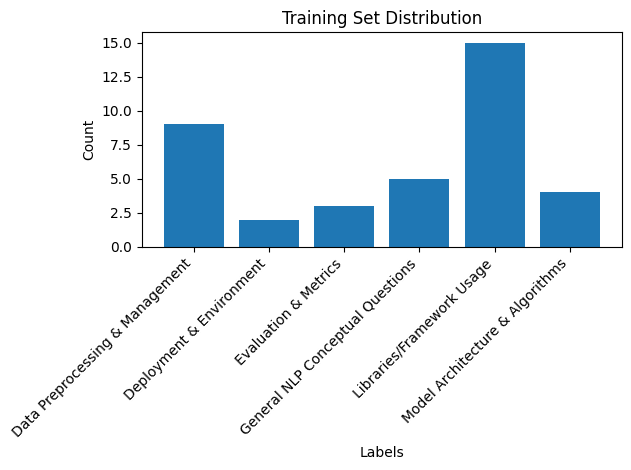

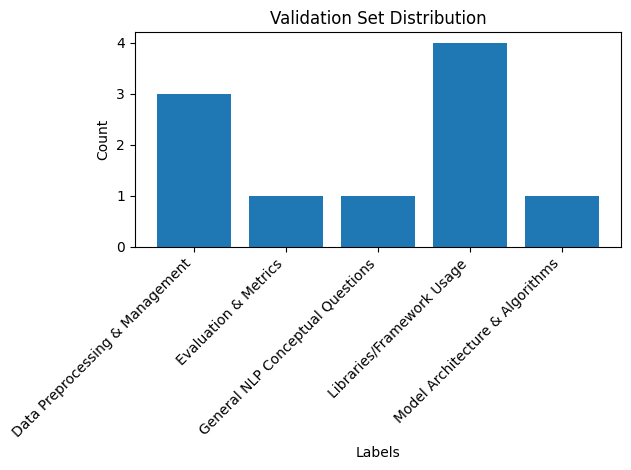

In [ ]:
# Plot distribution of training set
plot_class_distribution(y_train, label_encoder, title="Training Set Distribution")

# Plot distribution of validation set
plot_class_distribution(y_val, label_encoder, title="Validation Set Distribution")

Classification Report:
                                  precision    recall  f1-score   support

 Data Preprocessing & Management       1.00      0.67      0.80         3
            Evaluation & Metrics       0.00      0.00      0.00         1
General NLP Conceptual Questions       1.00      1.00      1.00         1
       Libraries/Framework Usage       0.67      0.50      0.57         4
 Model Architecture & Algorithms       0.25      1.00      0.40         1

                        accuracy                           0.60        10
                       macro avg       0.58      0.63      0.55        10
                    weighted avg       0.69      0.60      0.61        10



/Users/hasnain/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hasnain/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hasnain/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

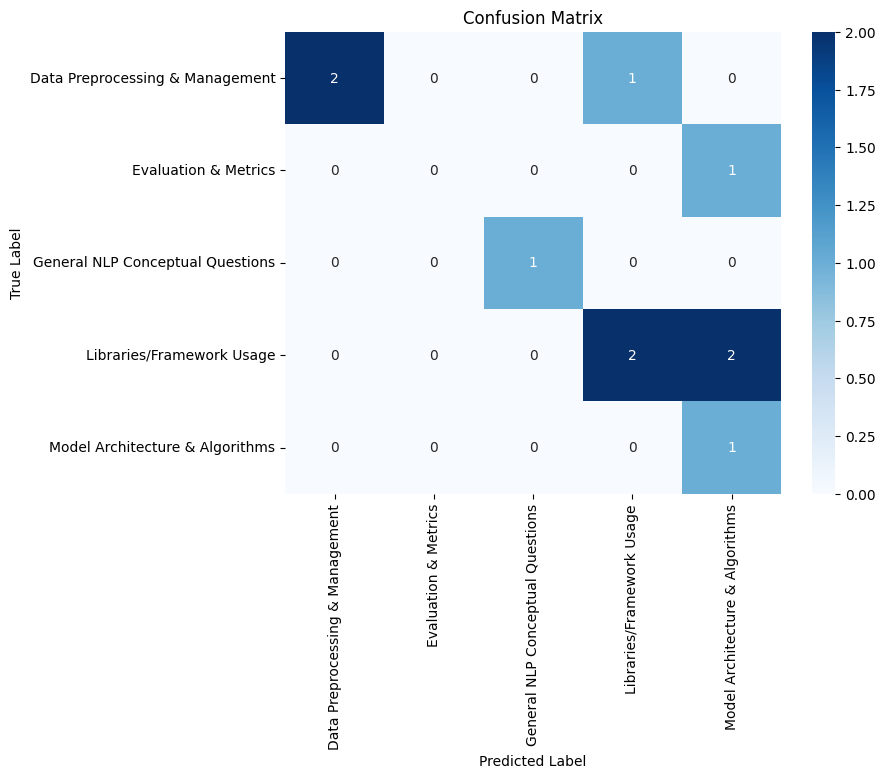

In [27]:
evaluate_model(model_path, X_val, y_val, label_encoder)

Describe issues with class imbalance here

This confirms our initial set of labeled data. We can now run BERT over this small subset, and check our evaluation results.

After manually labeling, we end up with the following class distribution:

In [ ]:
eq_cls_distr_df = pd.read_csv('labeled_data_class_distr_eq_final.csv')
print(eq_cls_distr_df.shape)
eq_cls_distr_df.head()

(115, 15)


,Unnamed: 0,QuestionId,Title,Description,Tags,AcceptedAnswer,OtherAnswers,clean_title,clean_description,clean_accepted_answer,clean_other_answers,tag_list,combined_title_desc,desc_length,human_label
0,0,57919736,Extract particular text data from string,"<p>I have a sample text like ""0 zacapa ambar 4...",<r><regex><nlp>,<p>Assuming your input is </p>\n\n<pre><code>x...,NaN,extract particular text data string,sample text like `` 0 zacapa ambar 40 1l '' wo...,assuming input x lt c `` 1 smirnoff espresso t...,NaN,"['r', 'regex', 'nlp']",trained models nlp new natural language proces...,53,Data Preprocessing & Management
1,1,12163362,Using a support vector classifier with polynom...,<p>I'm experimenting with different classifier...,<python><machine-learning><nlp><scikit-learn>,<p>In both cases you should tune the value of ...,NaN,using support vector classifier polynomial ker...,'m experimenting different classifiers impleme...,cases tune value regularization parameter c us...,NaN,"['python', 'machine-learning', 'nlp', 'scikit-...",error loading list adding list arabic plugin g...,239,Model Training & Tuning
2,2,10740767,Techniques for extracting regular expressions ...,<p>Let's suppose I have a data set of several ...,<regex><algorithm><nlp><machine-learning>,"<p>So far as I know, this is the subject of cu...",<p>This problem is usually framed as how to ge...,techniques extracting regular expressions labe...,let 's suppose data set several hundred thousa...,far know subject current research evolutionary...,problem usually framed generate finite automat...,"['regex', 'algorithm', 'nlp', 'machine-learning']",delete specific words file want delete stop wo...,104,Data Preprocessing & Management
3,3,2587757,Building dictionary of words from large text,<p>I have a text file containing posts in Engl...,<lucene><nlp>,"<p>Thanks to @Mikos' comment, I googled the te...","<p>Maybe you want to look at <a href=""http://g...",building dictionary words large text,text file containing posts english/italian wou...,thanks mikos comment googled term `` term-docu...,maybe want look gate infrastructure text-minin...,"['lucene', 'nlp']",extract entities folksonomies newbie nlp relat...,73,Data Preprocessing & Management
4,4,37133079,Choose the best NLP parsers,<p>I want to analyze a sentence using a contex...,<parsing><nlp>,<p>I recommend Stanford parser. It supports a ...,NaN,choose best nlp parsers,want analyze sentence using context free gramm...,recommend stanford parser supports powerful li...,NaN,"['parsing', 'nlp']",convert numeric words numeric python want conv...,34,Model Architecture & Algorithms


In [ ]:
eq_cls_distr_df['human_label'].value_counts()

,count
human_label,
Libraries/Framework Usage,19
Data Preprocessing & Management,18
Model Training & Tuning,16
Evaluation & Metrics,16
General NLP Conceptual Questions,16
Model Architecture & Algorithms,15
Deployment & Environment,15


In [ ]:
find_duplicates(eq_cls_distr_df, 'QuestionId')

Duplicates dataframe based on QuestionId: 0
Empty DataFrame
Columns: [Unnamed: 0, QuestionId, Title, Description, Tags, AcceptedAnswer, OtherAnswers, clean_title, clean_description, clean_accepted_answer, clean_other_answers, tag_list, combined_title_desc, desc_length, human_label]
Index: []


In [ ]:
model_path, trainer, X, y, X_train, X_val, y_train, y_val, label_encoder = run_bert_classifier_pipeline(eq_cls_distr_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted
1,No log,1.953345,0.260870,0.111183,0.072527,0.238095,0.121975,0.079599,0.260870
2,No log,1.973348,0.130435,0.032967,0.018634,0.142857,0.030100,0.017013,0.130435
3,2.006700,1.989675,0.173913,0.081633,0.060924,0.154762,0.086957,0.063299,0.173913
4,2.006700,1.985054,0.130435,0.032967,0.018634,0.142857,0.030100,0.017013,0.130435
5,1.986500,1.943939,0.173913,0.042328,0.024845,0.142857,0.051530,0.030246,0.173913
6,1.986500,1.939114,0.173913,0.042328,0.024845,0.142857,0.051530,0.030246,0.173913


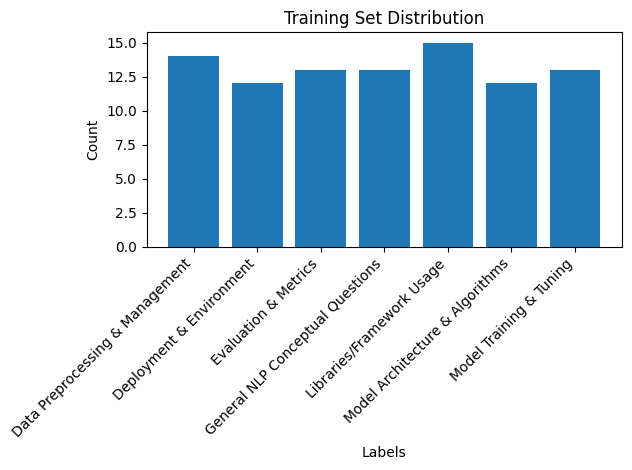

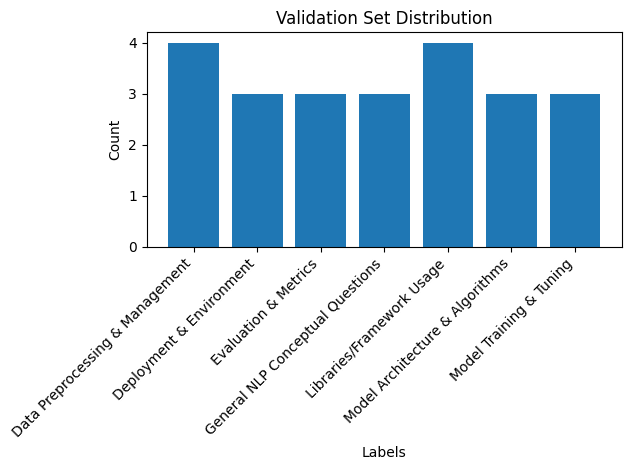

Classification Report:
                                  precision    recall  f1-score   support

 Data Preprocessing & Management       0.31      1.00      0.47         4
        Deployment & Environment       0.00      0.00      0.00         3
            Evaluation & Metrics       0.00      0.00      0.00         3
General NLP Conceptual Questions       0.20      0.67      0.31         3
       Libraries/Framework Usage       0.00      0.00      0.00         4
 Model Architecture & Algorithms       0.00      0.00      0.00         3
         Model Training & Tuning       0.00      0.00      0.00         3

                        accuracy                           0.26        23
                       macro avg       0.07      0.24      0.11        23
                    weighted avg       0.08      0.26      0.12        23



/Users/hasnain/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hasnain/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hasnain/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

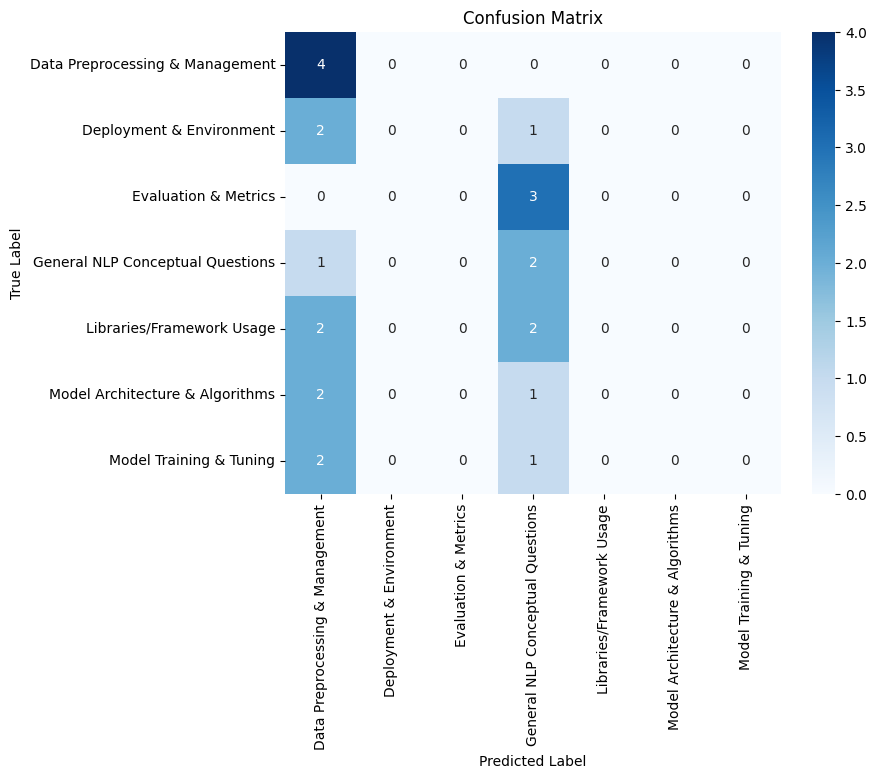

In [ ]:
# Plot distribution of training set
plot_class_distribution(y_train, label_encoder, title="Training Set Distribution")

# Plot distribution of validation set
plot_class_distribution(y_val, label_encoder, title="Validation Set Distribution")

evaluate_model(model_path, X_val, y_val, label_encoder)

In [ ]:
df_labeled_merged['human_label'].value_counts()

,count
human_label,
Libraries/Framework Usage,19
Data Preprocessing & Management,18
Model Training & Tuning,16
Evaluation & Metrics,16
General NLP Conceptual Questions,16
Model Architecture & Algorithms,15
Deployment & Environment,15


### Zero-Shot Classification

Given the results from our We use a zero-shot classifier (facebook/bart-large-mnli) to predict topics for posts based on the combined_title_desc column.

We define our candidate labels to match the 7 topics in the human_label column.

Since only a small subset of df_labeled_merged is manually labeled (~15 samples per category), we will filter out rows with a human label for evaluation.

We will do the following:
1. Set up the candidate labels and zero-shot classifier.
2. Run inference on the `combined_title_desc` column for all data.
3. Evaluate the classifier on the labeled subset.
4. Visualize the distribution of predicted topics.

#### Evaluation

Since only a subset of `df_labeled_merged` contains the `human_label`, we filter those rows out. We then generate a classification report and a confusion matrix to assess the model's performance on the labeled data.

After predicting the topics for every row, we can visualize the overall distribution.

*Note:* The zero-shot pipeline was run on Google Colab, to leverage their compute resources

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Classifying texts: 100%|██████████| 8489/8489 [1:03:14<00:00,  2.24it/s]


Classification Report:
                                   precision    recall  f1-score   support

 Data Preprocessing & Management       0.40      0.22      0.29        18
        Deployment & Environment       0.50      0.27      0.35        15
            Evaluation & Metrics       0.25      0.50      0.33        16
General NLP Conceptual Questions       0.40      0.12      0.19        16
       Libraries/Framework Usage       0.30      0.58      0.39        19
 Model Architecture & Algorithms       0.56      0.60      0.58        15
         Model Training & Tuning       0.71      0.31      0.43        16

                        accuracy                           0.37       115
                       macro avg       0.45      0.37      0.37       115
                    weighted avg       0.44      0.37      0.36       115



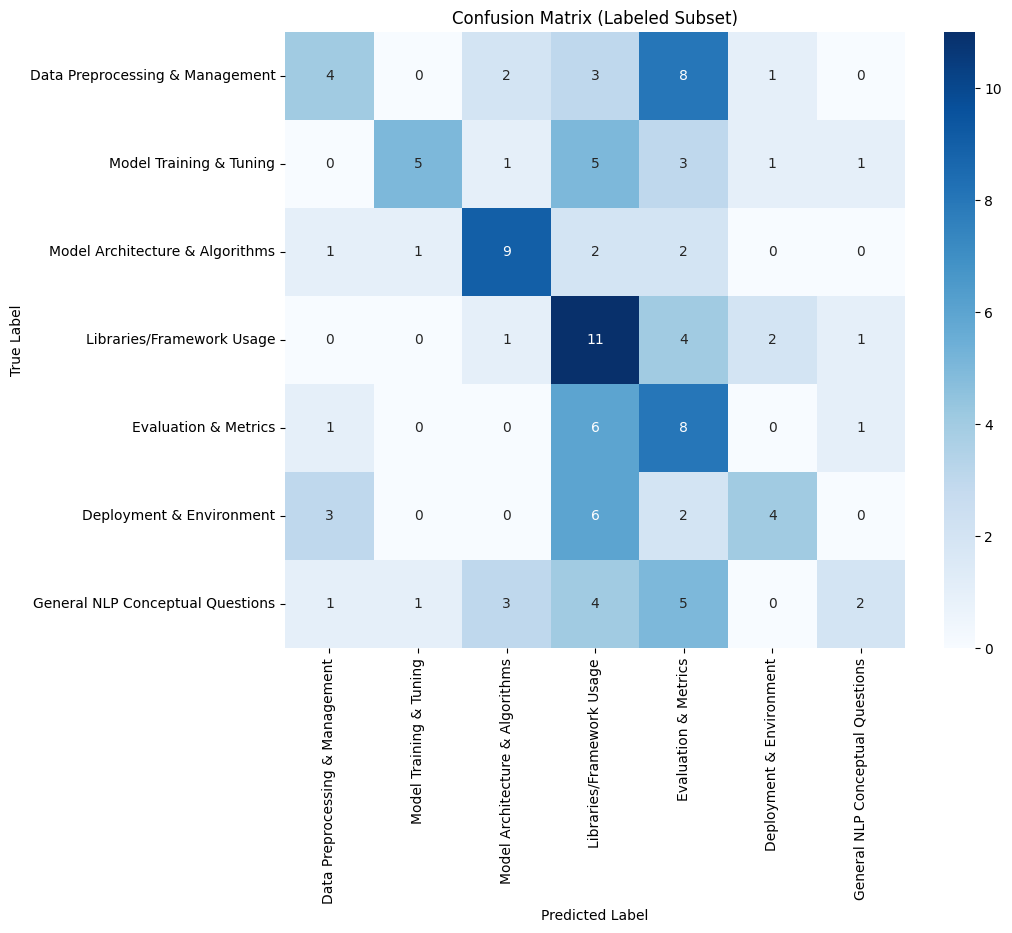

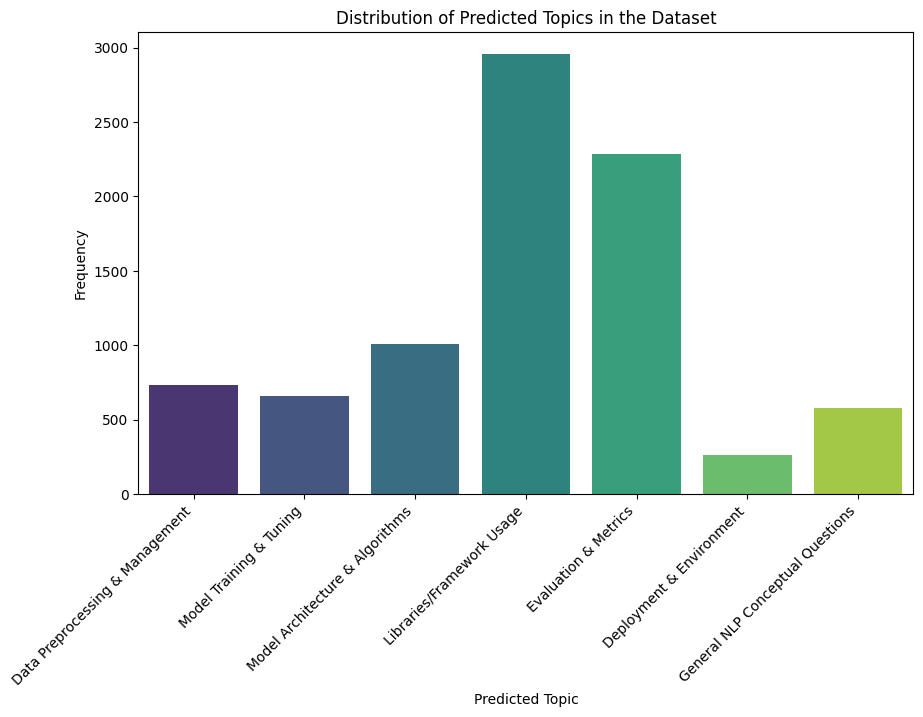

In [ ]:
'''
Define our candidate labels based on your manual topic categories.
'''
candidate_labels = [
    "Data Preprocessing & Management",
    "Model Training & Tuning",
    "Model Architecture & Algorithms",
    "Libraries/Framework Usage",
    "Evaluation & Metrics",
    "Deployment & Environment",
    "General NLP Conceptual Questions"
]

zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

'''
First ensure that the `combined_title_desc` column is of string type, then
apply the classifier to each row. The result is stored in a new column, 'predicted_label'.
'''
df_labeled_merged['combined_title_desc'] = df_labeled_merged['combined_title_desc'].astype(str)

# Helper function for classification of a single sample
def classify_text(text, candidate_labels):
    result = zero_shot_classifier(text, candidate_labels=candidate_labels, multi_label=False)
    
    # Pick top predicted label (highest score)
    return result['labels'][0]

'''
Classify over entire `combined_title_desc` column
'''
tqdm.pandas(desc="Classifying texts")
df_labeled_merged['predicted_label'] = df_labeled_merged['combined_title_desc'].progress_apply(
    lambda x: classify_text(x, candidate_labels)
)

'''
Filter & generate report
'''
df_eval = df_labeled_merged[df_labeled_merged['human_label'].notna()]
report = classification_report(df_eval['human_label'], df_eval['predicted_label'], zero_division=0)
print("Classification Report:\n", report)

cm = confusion_matrix(df_eval['human_label'], df_eval['predicted_label'], labels=candidate_labels)
cm_df = pd.DataFrame(cm, index=candidate_labels, columns=candidate_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Labeled Subset)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Count frequency of each predicted label across the full dataset
pred_counts = df_labeled_merged['predicted_label'].value_counts().reindex(candidate_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')

plt.xlabel("Predicted Topic")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Topics in the Dataset")
plt.show()


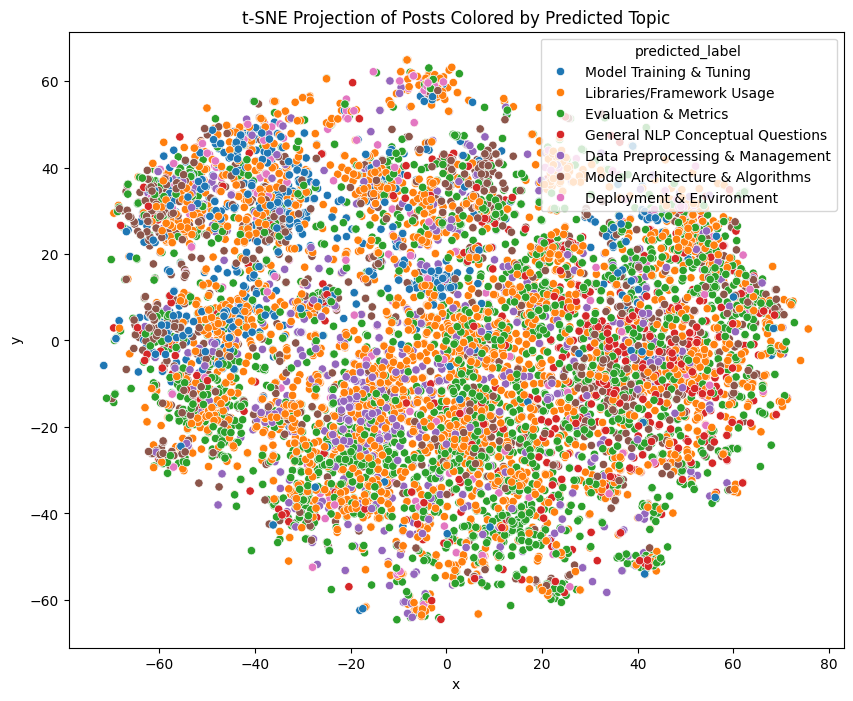

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

# Use a sentence transformer to get embeddings for each combined_title_desc (if not already done)
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_labeled_merged['combined_title_desc'].tolist())

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

tsne_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
tsne_df['predicted_label'] = df_labeled_merged['predicted_label']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='predicted_label', palette="tab10")
plt.title("t-SNE Projection of Posts Colored by Predicted Topic")
plt.show()

plt.savefig('t-sne.jpg')

From the t-SNE plot, we can see that clusters are not clearly defined. We can observe small pockets of localized clusters. This corroborates the observation of a lack of a clear elbow point with k-means.

Something we can do here is to overlay our manually labeled samples on top of the t-sne axis, to check for any patterns within the labels. We will add the 'human_label' column to `tsne_df`. This assumes that the index of `df_labeled_merged` corresponds exactly to the index of `tsne_df` (i.e., the order of rows is the same).

In the code block below, we will assume `tsne_df` is already created from the t-SNE operation, and that it currently only contains the 2D coordinates "x" and "y".

For example:
```
embeddings_2d = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
```

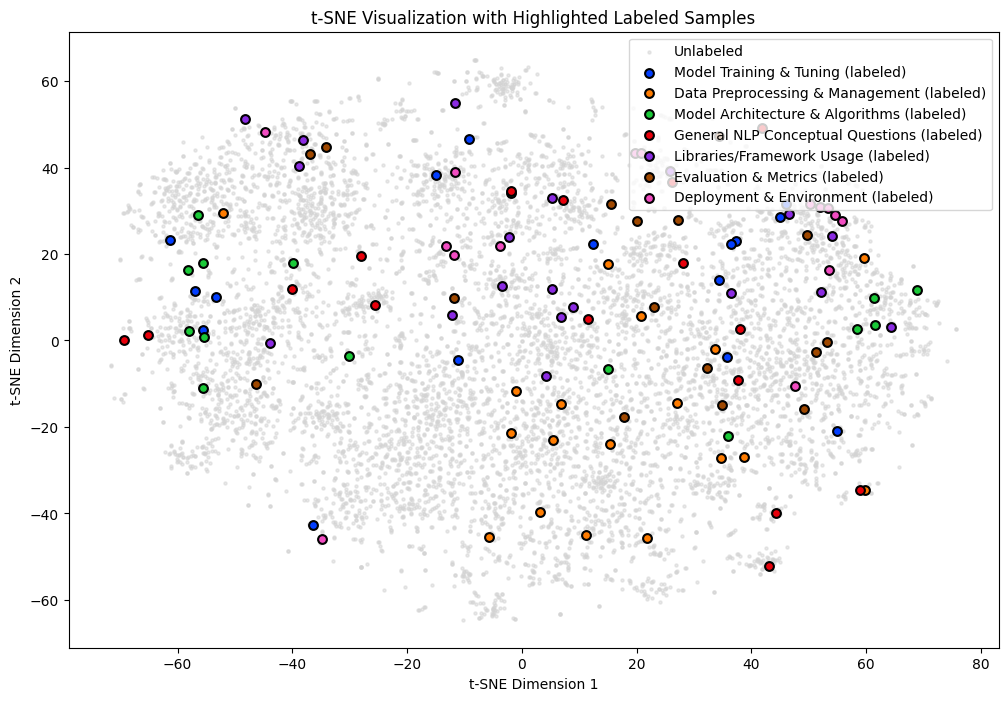

In [ ]:
# Check if df_labeled_merged has the 'human_label' column:
if 'human_label' not in df_labeled_merged.columns:
    raise KeyError("df_labeled_merged does not contain the column 'human_label'.")

# Make a copy to add new columns
tsne_df = tsne_df.copy()

tsne_df['human_label'] = df_labeled_merged['human_label'].values

# Create mask for labeled samples (those with a non-null human_label)
mask_labeled = tsne_df['human_label'].notna()
tsne_labeled = tsne_df[mask_labeled]
tsne_unlabeled = tsne_df[~mask_labeled]

plt.figure(figsize=(12, 8))

# Unlabeled
plt.scatter(tsne_unlabeled['x'], tsne_unlabeled['y'],
            c='lightgray', alpha=0.5, s=5, label="Unlabeled")

# Get unique labeled categories and define a color palette.
unique_labels = tsne_labeled['human_label'].unique()
palette = sns.color_palette("bright", len(unique_labels))

# Plot each group of labeled points with distinct colors and larger markers.
for i, label in enumerate(unique_labels):
    subset = tsne_labeled[tsne_labeled['human_label'] == label]
    plt.scatter(subset['x'], subset['y'],
                c=[palette[i]],
                label=f"{label} (labeled)",
                s=40,           # larger marker size
                edgecolor='black',  # black outline for better contrast
                linewidth=1.5)

plt.legend()
plt.title("t-SNE Visualization with Highlighted Labeled Samples")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [ ]:
plt.savefig('t-sne-labeled.jpg')

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume your zero-shot classifier returns a dictionary with a "score" field for the top label.
# Here, we create a column with these confidence scores.
df_labeled_merged['predicted_confidence'] = df_labeled_merged['zero_shot_result'].apply(lambda res: res['scores'][0])  # adjust based on your output

plt.figure(figsize=(8, 6))
plt.hist(df_labeled_merged['predicted_confidence'], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Histogram of Model Confidence Scores")
plt.show()


### BERTopic

In [30]:
docs = df["combined_title_desc"].fillna("").tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=30,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine')

hdbscan_model = HDBSCAN(min_cluster_size=50,
                        min_samples=200,
                        cluster_selection_epsilon=0.01)

topic_model = BERTopic(hdbscan_model=hdbscan_model, umap_model=umap_model,
                       embedding_model=embedding_model, verbose=True,
                       min_topic_size=200)
topics, probs = topic_model.fit_transform(docs)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-04-18 21:30:43,934 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:40<00:00,  6.62it/s]
2025-04-18 21:31:24,443 - BERTopic - Embedding - Completed ✓
2025-04-18 21:31:24,444 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-18 21:31:35,747 - BERTopic - Dimensionality - Completed ✓
2025-04-18 21:31:35,748 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-18 21:31:36,053 - BERTopic - Clu

In [32]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2244,-1_gt_lt_quot_text,"[gt, lt, quot, text, import, word, file, words...",[building character-level ngram language model...
1,0,4354,0_quot_text_words_gt,"[quot, text, words, gt, word, nlp, lt, like, s...",[problems using spacy tokenizer special charac...
2,1,969,1_quot_model_self_nan,"[quot, model, self, nan, tf, keras, tokenizer,...",[error node 'binary_crossentropy/cast cast str...
3,2,771,2_model_word2vec_gensim_similarity,"[model, word2vec, gensim, similarity, word, wo...",[pythonic way obtain distance matrix word vect...
4,3,151,3_sklearn_import_data_text,"[sklearn, import, data, text, fit, x_train, pr...",[text classification python hi new python prog...


In [34]:
topic_info = topic_model.get_topic_info()

# Examine top words for each topic
for topic_id in topic_info["Topic"].unique():
    if topic_id == -1:
        continue
    print(f"\nTopic {topic_id} Key Words:")
    print(topic_model.get_topic(topic_id))


Topic 0 Key Words:
[('quot', 0.054783263018281673), ('text', 0.037779337259153535), ('words', 0.02862163461933387), ('gt', 0.0280828559407427), ('word', 0.02779700984979745), ('nlp', 0.027223833271614654), ('lt', 0.024503383909989768), ('like', 0.023761717884085685), ('sentence', 0.021265289876940284), ('list', 0.02053186562272467)]

Topic 1 Key Words:
[('quot', 0.08007262022898552), ('model', 0.06832204688314618), ('self', 0.05227329940086542), ('nan', 0.04897937557553462), ('tf', 0.03717690668691659), ('keras', 0.034797417021909804), ('tokenizer', 0.031020401626241714), ('shape', 0.027167499985301293), ('loss', 0.0265753548455117), ('torch', 0.025281929267723713)]

Topic 2 Key Words:
[('model', 0.060433606588558744), ('word2vec', 0.054639334862393855), ('gensim', 0.051888561232482915), ('similarity', 0.04823409327473171), ('word', 0.04119306805754235), ('words', 0.036150616121771284), ('vectors', 0.036016675581206206), ('quot', 0.03441619820296876), ('vector', 0.027087007254154975),

In [ ]:
from gensim.corpora import Dictionary

lda_df = df.copy()
lda_df['combined_title_desc_tokens'] = lda_df['combined_title_desc'].apply(
    lambda x: process_text(x, return_as_tokens=True)
)
dictionary = Dictionary(lda_df['combined_title_desc_tokens'])
corpus = [dictionary.doc2bow(text) for text in lda_df['combined_title_desc_tokens']]

from gensim.models import LdaModel

num_topics = 8
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

In [37]:
def get_topic(doc_bow):
    topic_probs = lda_model.get_document_topics(doc_bow)
    return max(topic_probs, key=lambda x: x[1])[0] if topic_probs else -1

lda_df['LDA_Topic'] = [get_topic(doc) for doc in corpus]
print(lda_df['LDA_Topic'].value_counts())


LDA_Topic
4    5749
6     868
2     664
3     525
7     363
0     152
5     125
1      43
Name: count, dtype: int64


In [39]:
topics = lda_model.print_topics(num_words=10)
for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")

[(0,
  '0.232*"--" + 0.028*"model" + 0.014*"gensim" + 0.008*"word2vec" + 0.005*"doc2vec" + 0.005*"fasttext" + 0.005*"load" + 0.004*"error" + 0.003*"lda" + 0.003*"documents"'),
 (1,
  '0.013*"\'nn" + 0.009*"\'in" + 0.008*"0000" + 0.006*"\'the" + 0.006*"\'nnp" + 0.006*"\'to" + 0.006*"0.0" + 0.005*"\'is" + 0.005*"\'dependentgloss" + 0.005*"\'dependent"'),
 (2,
  '0.055*"0" + 0.028*"1" + 0.017*"2" + 0.014*"model" + 0.013*"3" + 0.011*"x" + 0.009*"5" + 0.009*"4" + 0.008*"nan" + 0.006*"6"'),
 (3,
  '0.224*"``" + 0.074*"gt" + 0.056*"lt" + 0.009*"string" + 0.007*"/a" + 0.007*"1" + 0.006*"new" + 0.005*"2" + 0.004*"import" + 0.004*"//"'),
 (4,
  '0.012*"text" + 0.011*"words" + 0.011*"like" + 0.010*"using" + 0.009*"would" + 0.008*"\'m" + 0.008*"n\'t" + 0.007*"want" + 0.007*"\'s" + 0.007*"use"'),
 (5,
  '0.028*"word" + 0.014*"similarity" + 0.014*"vector" + 0.013*"vectors" + 0.013*"noun" + 0.011*"word2vec" + 0.010*"wordnet" + 0.010*"n" + 0.009*"dog" + 0.008*"cosine"'),
 (6,
  '0.021*"import" + 0.017

### References

1. Reimers, N. and Gurevych, I., 2023. *Sentence Transformers – Clustering with Sentence-BERT embeddings*. [online] SBERT.net. Available at: <https://sbert.net/examples/sentence_transformer/applications/clustering/README.html> [Accessed 23 March 2025].

2. Danushi, D.K., 2023. *Topic Modelling with BERTopic*. [online] Medium.com. Available at: <https://medium.com/@danushidk507/topic-modelling-with-bertopic-249095144555> [Accessed 03 April 2025].

3. Blei, D.M., Ng, A.Y. and Jordan, M.I., 2003. Latent Dirichlet Allocation. *Journal of Machine Learning Research*, 3(Jan), pp.993–1022.

4. Yin, W., Hay, J. and Roth, D., 2019. Benchmarking Zero-Shot Text Classification: Datasets, Evaluation and Entailment Approach. In: *EMNLP-IJCNLP 2019*. pp.3914–3923.

5. Reimers, N. and Gurevych, I., 2019. Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. In: *EMNLP-IJCNLP 2019*. pp.3982–3992.

6. Wolf, T., Debut, L., Sanh, V., et al., 2020. Transformers: State-of-the-Art Natural Language Processing. In: *EMNLP 2020 – System Demonstrations*. pp.38–45.

7. Hugging Face, 2025. *Model Card: facebook/bart-large-mnli – NLI-based Zero Shot Text Classification*. [online] Available at: <https://huggingface.co/facebook/bart-large-mnli> [Accessed 11 April 2025].

8. Pedregosa, F., Varoquaux, G., Gramfort, A., et al., 2011. Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, pp.2825–2830.

9. Grotefend, A., 2017. *Text Mining of Stack Overflow Questions*. [online] Stack Overflow Blog. Available at: <https://stackoverflow.blog/2017/03/15/text-mining-stack-overflow-questions/> [Accessed 08 April 2025].

10. Grootendorst, M., 2022. *BERTopic – Leveraging BERT embeddings and c-TF-IDF for topic modeling*. [online] Available at: <https://maartengr.github.io/BERTopic/> [Accessed 01 April 2025].

11. Mueller, A., 2018. *WordCloud for Python – Documentation and tutorial*. [online] Available at: <https://amueller.github.io/word_cloud/> [Accessed 26 March 2025].

12. Matplotlib Community, 2007. Matplotlib: A 2D Graphics Environment. *IEEE Computing in Science & Engineering*. [online] Available at: <https://matplotlib.org/stable/users/project/citing.html> [Accessed 28 March 2025].

13. Tahaei, M., Vaniea, K. and Saphra, N., 2020. Understanding Privacy-Related Questions on Stack Overflow. In: *Proceedings of the 2020 CHI Conference on Human Factors in Computing Systems*. pp.1–13. ACM. Available at: <https://doi.org/10.1145/3313831.3376768> [Accessed 20 March 2025].

14. Croft, R., Xie, Y., Zahedi, M., Babar, M.A. and Treude, C., 2022. An Empirical Study of Developers’ Discussions About Security Challenges of Different Programming Languages. *Empirical Software Engineering*, 27(1), Article 27. Available at: <https://doi.org/10.1007/s10664-021-10054-w> [Accessed 15 April 2025].

15. Lopez, T., Tun, T., Bandara, A., Levine, M., Nuseibeh, B. and Sharp, H., 2019. An Anatomy of Security Conversations in Stack Overflow. In: *Proceedings of the 41st ACM/IEEE International Conference on Software Engineering*. pp.31–40. IEEE. Available at: <https://doi.org/10.1109/ICSE-SEIS.2019.00012> [Accessed 26 March 2025].